### Lending Club - Part 4 - Project Goal 1.

Project Goals:
1. At loan origination: is my model able to predict if a customer will fully pay off their debt or will they incur a charge off
2. Multiclassification exercise: the objective of the second part is to get experience with multiclassification.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

from sklearn.kernel_approximation import Nystroem
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve

In [2]:
df = pd.read_csv('./lendingclub_processed.csv')

In [3]:
df.head()

,Unnamed: 0,loan_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,0,3600.0,3600.0,36,13.99,123.03,55000.0,Fully Paid,5.91,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,24700.0,24700.0,36,11.99,820.28,65000.0,Fully Paid,16.06,1.0,...,1,0,0,0,0,0,0,0,0,0
2,2,20000.0,20000.0,60,10.78,432.66,63000.0,Fully Paid,10.78,0.0,...,0,0,0,0,0,0,0,0,0,0
3,3,35000.0,35000.0,60,14.85,829.90,110000.0,Current,17.06,0.0,...,0,0,0,0,0,0,0,0,0,0
4,4,10400.0,10400.0,60,22.45,289.91,104433.0,Fully Paid,25.37,1.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df = df.drop('Unnamed: 0', axis=1)

In [5]:
df.head()

,loan_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,fico_range_high,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,3600.0,3600.0,36,13.99,123.03,55000.0,Fully Paid,5.91,0.0,679.0,...,0,0,0,0,0,0,0,0,0,0
1,24700.0,24700.0,36,11.99,820.28,65000.0,Fully Paid,16.06,1.0,719.0,...,1,0,0,0,0,0,0,0,0,0
2,20000.0,20000.0,60,10.78,432.66,63000.0,Fully Paid,10.78,0.0,699.0,...,0,0,0,0,0,0,0,0,0,0
3,35000.0,35000.0,60,14.85,829.90,110000.0,Current,17.06,0.0,789.0,...,0,0,0,0,0,0,0,0,0,0
4,10400.0,10400.0,60,22.45,289.91,104433.0,Fully Paid,25.37,1.0,699.0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data_info = pd.read_csv('./Lending Club Data Dictionary Approved.csv',index_col='LoanStatNew', encoding = "ISO-8859-1")

In [7]:
def feat_info(col_name):
    print(data_info.loc[col_name]['Description'])

In [8]:
feat_info('total_pymnt')

Payments received to date for total amount funded


In [9]:
feat_info('last_fico_range_high')

The upper boundary range the borrowers last FICO pulled belongs to.


total_pymnt and last_fico_range_high are features after loan origination. In this project, my goal is to build a model that is able to predict based on a feature set at loan origination if a customer will fully pay off their debt or incur a charge off. Hence I will drop this two features.

In [10]:
df = df.drop(['total_pymnt', 'last_fico_range_high'], axis=1)

Because I am interested in building a model for predicting if a new customer will fully pay off their debt or incur a charge off at loan origination, I do not need the data for current customers, I will drop those rows

In [11]:
df['loan_status'].unique()

array(['Fully Paid', 'Current', 'Charged Off'], dtype=object)

In [12]:
index = df[df['loan_status'] == 'Current'].index

In [13]:
df = df.drop(index, axis=0)

In [14]:
df['loan_status'].unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

In [15]:
np.unique(df['loan_status'])

array(['Charged Off', 'Fully Paid'], dtype=object)

In [16]:
df['loan_status'] = df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})

Train, Validation, Test split

In [17]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [19]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

In [20]:
len(X_train)/len(df)

0.6999997766825297

In [21]:
len(X_val)/len(df)

0.15000011165873517

In [22]:
len(X_test)/len(df)

0.15000011165873517

## Modelling and validation

In this section, I will run multiple different classifers while using a gridsearch for hyperparameter tunning.
I will then do a final evaluation using cross validation for balanced accuracy and pick a model that also gives the best precision and recall. After which I will do a final test with my test set. 

## Logistic Regression 

In [24]:
model = LogisticRegression()

In [124]:
C = np.logspace(-6, -1, 6)

In [125]:
C

array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])

In [126]:
param_grid = {'clf__penalty': ['l1', 'l2', 'elasticnet'],
             'clf__C': C,
             'clf__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
             'clf__solver': ['saga'],
             'clf__max_iter': [5000],
             'clf__n_jobs' : [-1],
             'clf__warm_start' : ['True'],
             'clf__class_weight' : ['balanced'],
             'clf__random_state' : [42]}

In [127]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clf', model)
                ])

In [128]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0, error_score='raise')

In [129]:
start=datetime.now()
grid.fit(X_train,y_train)
print(datetime.now()-start)

C:\Users\kaile\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "


4:09:05.567043


In [130]:
preds = grid.predict(X_val)

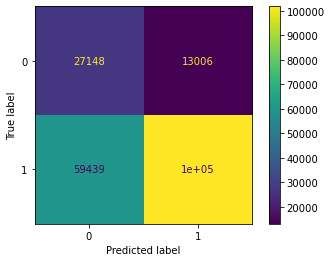

In [131]:
plot_confusion_matrix(grid, X_val, y_val)

In [132]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.31      0.68      0.43     40154
           1       0.89      0.63      0.74    161353

    accuracy                           0.64    201507
   macro avg       0.60      0.65      0.58    201507
weighted avg       0.77      0.64      0.68    201507



In [134]:
grid.best_params_

{'clf__C': 0.1,
 'clf__class_weight': 'balanced',
 'clf__l1_ratio': 0.1,
 'clf__max_iter': 5000,
 'clf__n_jobs': -1,
 'clf__penalty': 'l2',
 'clf__random_state': 42,
 'clf__solver': 'saga',
 'clf__warm_start': 'True'}

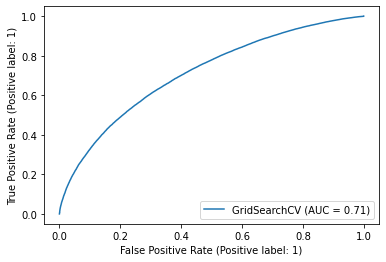

In [135]:
plot_roc_curve(grid, X_val, y_val)

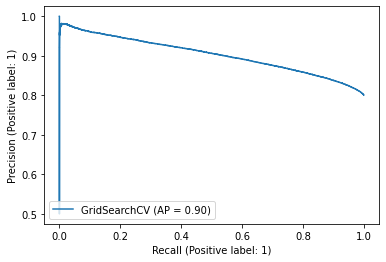

In [136]:
# plot_precision_recall_curve(grid,X_val,y_val, pos_label=0)

In [139]:
joblib.dump(grid, 'logistic_regression.pkl')

['logistic_regression.pkl']

In [25]:
grid = joblib.load('logistic_regression.pkl')

If the goal is to be able to predict true positives for charge off as much as I can and I don't mind a higher rate of false negatives, I could raise the threshold probability bar for predicting fully paid which in turn would give me a better recall.

In [26]:
grid.predict_proba(X_val)

array([[0.44626958, 0.55373042],
       [0.72426384, 0.27573616],
       [0.80149388, 0.19850612],
       ...,
       [0.53785482, 0.46214518],
       [0.11797849, 0.88202151],
       [0.13868285, 0.86131715]])

In [36]:
preds_var_thresh = (grid.predict_proba(X_val)[:,1]>=0.60).astype(int)

In [37]:
preds = grid.predict(X_val)

In [38]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.31      0.68      0.43     40154
           1       0.89      0.63      0.74    161353

    accuracy                           0.64    201507
   macro avg       0.60      0.65      0.58    201507
weighted avg       0.77      0.64      0.68    201507



In [39]:
print(classification_report(y_val, preds_var_thresh))

              precision    recall  f1-score   support

           0       0.27      0.84      0.41     40154
           1       0.92      0.44      0.59    161353

    accuracy                           0.52    201507
   macro avg       0.59      0.64      0.50    201507
weighted avg       0.79      0.52      0.56    201507



In [40]:
confusion_matrix(y_val, preds_var_thresh)

array([[33597,  6557],
       [90489, 70864]], dtype=int64)

In [41]:
confusion_matrix(y_val, preds)

array([[ 27148,  13006],
       [ 59439, 101914]], dtype=int64)

In [111]:
grid = joblib.load('logistic_regression.pkl')

In [112]:
preds = grid.predict(X_val)

In [115]:
results = pd.DataFrame(classification_report(y_val, preds,output_dict=True))

In [116]:
results

,0,1,accuracy,macro avg,weighted avg
precision,0.313534,0.886826,0.640484,0.600180,0.772587
recall,0.676097,0.631621,0.640484,0.653859,0.640484
f1-score,0.428401,0.737777,0.640484,0.583089,0.676129
support,40154.000000,161353.000000,0.640484,201507.000000,201507.000000


In [122]:
np.array(results.loc['f1-score'])

array([0.42840123, 0.73777749, 0.64048395, 0.58308936, 0.67612854])

In [129]:
f1 = ['logistic_regression']
for i in np.array(results.loc['f1-score']):
    f1.append(i)

In [130]:
f1

['logistic_regression',
 0.4284012277005862,
 0.7377774882091266,
 0.6404839534110478,
 0.5830893579548564,
 0.6761285412025217]

In [135]:
model_results.append(f1)

In [26]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    scores = cross_val_score(model.best_estimator_, X, y, scoring='balanced_accuracy', cv=cv, n_jobs=4)
    return scores

In [76]:
grid = joblib.load('logistic_regression.pkl')

              precision    recall  f1-score   support

           0       0.31      0.68      0.43     40154
           1       0.89      0.63      0.74    161353

    accuracy                           0.64    201507
   macro avg       0.60      0.65      0.58    201507
weighted avg       0.77      0.64      0.68    201507



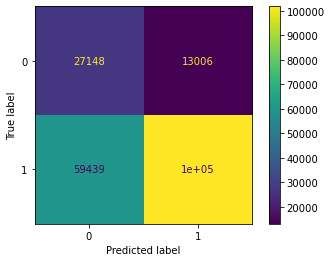

In [77]:
preds = grid.predict(X_val)
plot_confusion_matrix(grid, X_val, y_val)
print(classification_report(y_val, preds))

In [78]:
start=datetime.now()
scores = evaluate_model(grid, X_train, y_train)
print(datetime.now()-start)

1:07:31.791267


In [79]:
scores

array([0.65299662, 0.65364081, 0.65369848, 0.65354847, 0.65440871,
       0.65237866, 0.65414596, 0.65431107, 0.65349375, 0.65407425,
       0.65558765, 0.65273228, 0.65383312, 0.65354237, 0.65325788])

In [80]:
scores_df['logistic_regression'] = scores

In [81]:
scores_df

,logistic_regression,random_forest
0,0.652997,0.653588
1,0.653641,0.652926
2,0.653698,0.654439
3,0.653548,0.653376
4,0.654409,0.652237
5,0.652379,0.652978
6,0.654146,0.652966
7,0.654311,0.653879
8,0.653494,0.653196
9,0.654074,0.652584


In [82]:
joblib.dump(scores_df, 'scores_df_1.pkl')

['scores_df_1.pkl']

## Random Forest Classifier

In [23]:
model = RandomForestClassifier()

In [48]:
def _compute_class_weight_dictionary(df):
    # helper for returning a dictionary instead of an array
    classes = np.unique(df['loan_status'])
    class_weight = compute_class_weight("balanced", np.unique(df['loan_status']), np.array(df['loan_status']))
    class_weight_dict = dict(zip(classes, class_weight))
    return class_weight_dict 

In [49]:
weights = _compute_class_weight_dictionary(df)

C:\Users\kaile\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 0 1 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [50]:
depth = np.linspace(10, 20, 3).astype(int)

In [51]:
depth

array([10, 15, 20])

In [52]:
len(X_train.columns)

121

In [53]:
np.sqrt(121)

11.0

In [30]:
weights

{0: 2.5045471833191644, 1: 0.6247164457291774}

In [42]:
param_grid = {'clf__n_estimators': [150, 200],
             'clf__max_depth': depth,
             'clf__max_features': [11, 15],
             'clf__bootstrap': ['True', 'False'],
             'clf__criterion': ['gini', 'entropy'],
             'clf__n_jobs' : [-1],
             'clf__warm_start' : ['False'],
             'clf__class_weight' : [weights],
             'clf__random_state' : [42]}

In [43]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clf', model)
                ])

In [44]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', verbose=0, n_jobs=8)

In [45]:
start=datetime.now()
grid.fit(X_train,y_train)
print(datetime.now()-start)

4:56:53.178384


              precision    recall  f1-score   support

           0       0.32      0.64      0.43     40154
           1       0.88      0.66      0.76    161353

    accuracy                           0.66    201507
   macro avg       0.60      0.65      0.59    201507
weighted avg       0.77      0.66      0.69    201507



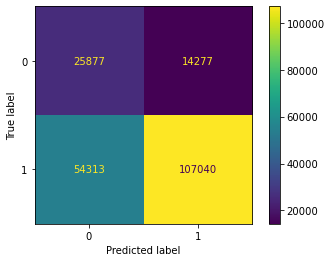

In [46]:
preds = grid.predict(X_val)
plot_confusion_matrix(grid, X_val, y_val)
print(classification_report(y_val, preds))

In [47]:
grid.best_params_

{'clf__bootstrap': 'True',
 'clf__class_weight': {0: 2.5045471833191644, 1: 0.6247164457291774},
 'clf__criterion': 'gini',
 'clf__max_depth': 15,
 'clf__max_features': 15,
 'clf__n_estimators': 200,
 'clf__n_jobs': -1,
 'clf__random_state': 42,
 'clf__warm_start': 'False'}

Second search attempt, searching hyperparamter values closer to previous best params

In [49]:
param_grid = {'clf__n_estimators': [200, 250],
             'clf__max_depth': [14, 15, 16],
             'clf__max_features': [15, 19, 23],
             'clf__bootstrap': ['True'],
             'clf__criterion': ['gini'],
             'clf__n_jobs' : [-1],
             'clf__warm_start' : ['False'],
             'clf__class_weight' : [weights],
             'clf__random_state' : [42]}

In [50]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clf', model)
                ])

In [51]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', verbose=0, n_jobs=8)

In [52]:
start=datetime.now()
grid.fit(X_train,y_train)
print(datetime.now()-start)

3:16:35.046117


              precision    recall  f1-score   support

           0       0.33      0.63      0.43     40154
           1       0.88      0.68      0.77    161353

    accuracy                           0.67    201507
   macro avg       0.60      0.65      0.60    201507
weighted avg       0.77      0.67      0.70    201507



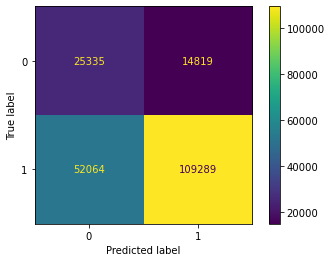

In [53]:
preds = grid.predict(X_val)
plot_confusion_matrix(grid, X_val, y_val)
print(classification_report(y_val, preds))

In [54]:
grid.best_params_

{'clf__bootstrap': 'True',
 'clf__class_weight': {0: 2.5045471833191644, 1: 0.6247164457291774},
 'clf__criterion': 'gini',
 'clf__max_depth': 15,
 'clf__max_features': 23,
 'clf__n_estimators': 250,
 'clf__n_jobs': -1,
 'clf__random_state': 42,
 'clf__warm_start': 'False'}

Third search attempt, searching hyperparamter values closer to previous best params

In [31]:
model = RandomForestClassifier()

In [ ]:
param_grid = {'clf__n_estimators': [250, 300],
             'clf__max_depth': [15],
             'clf__max_features': [23, 27, 30, 35],
             'clf__bootstrap': ['True'],
             'clf__criterion': ['gini'],
             'clf__n_jobs' : [-1],
             'clf__warm_start' : ['False'],
             'clf__class_weight' : [weights],
             'clf__random_state' : [42]}

In [57]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clf', model)
                ])

In [58]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', verbose=0, n_jobs=8)

In [59]:
start=datetime.now()
grid.fit(X_train,y_train)
print(datetime.now()-start)

2:31:14.137947


              precision    recall  f1-score   support

           0       0.33      0.62      0.43     40154
           1       0.88      0.68      0.77    161353

    accuracy                           0.67    201507
   macro avg       0.60      0.65      0.60    201507
weighted avg       0.77      0.67      0.70    201507



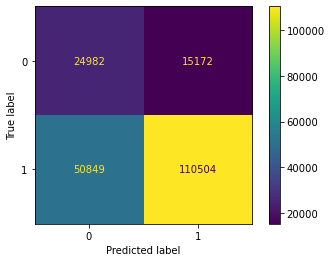

In [60]:
preds = grid.predict(X_val)
plot_confusion_matrix(grid, X_val, y_val)
print(classification_report(y_val, preds))

In [61]:
grid.best_params_

{'clf__bootstrap': 'True',
 'clf__class_weight': {0: 2.5045471833191644, 1: 0.6247164457291774},
 'clf__criterion': 'gini',
 'clf__max_depth': 15,
 'clf__max_features': 27,
 'clf__n_estimators': 300,
 'clf__n_jobs': -1,
 'clf__random_state': 42,
 'clf__warm_start': 'False'}

Fourth search attempt, searching hyperparamter values closer to previous best params

In [57]:
model = RandomForestClassifier()

In [58]:
param_grid = {'clf__n_estimators': [300, 350],
             'clf__max_depth': [15],
             'clf__max_features': [26, 27, 28],
             'clf__bootstrap': ['True'],
             'clf__criterion': ['gini'],
             'clf__n_jobs' : [-1],
             'clf__warm_start' : ['False'],
             'clf__class_weight' : [weights],
             'clf__random_state' : [42]}

In [59]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clf', model)
                ])

In [60]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', verbose=0, n_jobs=8)

In [61]:
start=datetime.now()
grid.fit(X_train,y_train)
print(datetime.now()-start)

2:08:09.516869


              precision    recall  f1-score   support

           0       0.33      0.62      0.43     40154
           1       0.88      0.68      0.77    161353

    accuracy                           0.67    201507
   macro avg       0.60      0.65      0.60    201507
weighted avg       0.77      0.67      0.70    201507



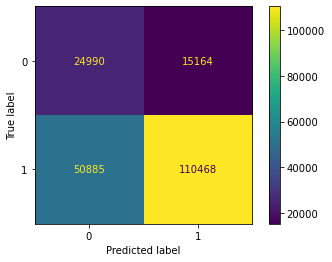

In [62]:
preds = grid.predict(X_val)
plot_confusion_matrix(grid, X_val, y_val)
print(classification_report(y_val, preds))

In [63]:
grid.best_params_

{'clf__bootstrap': 'True',
 'clf__class_weight': {0: 2.5045471833191644, 1: 0.6247164457291774},
 'clf__criterion': 'gini',
 'clf__max_depth': 15,
 'clf__max_features': 27,
 'clf__n_estimators': 350,
 'clf__n_jobs': -1,
 'clf__random_state': 42,
 'clf__warm_start': 'False'}

In [64]:
joblib.dump(grid, 'random_forest.pkl')

['random_forest.pkl']

In [139]:
grid = joblib.load('random_forest.pkl')
preds = grid.predict(X_val)
results = pd.DataFrame(classification_report(y_val, preds,output_dict=True))
f1 = ['random_forest']
for i in np.array(results.loc['f1-score']):
    f1.append(i)
model_results.append(f1)

In [39]:
grid = joblib.load('random_forest.pkl')

In [70]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    scores = cross_val_score(model.best_estimator_, X.values, y.values, scoring='balanced_accuracy', cv=cv, n_jobs=4, error_score="raise")
    return scores

In [71]:
start=datetime.now()
scores = evaluate_model(grid, X_train, y_train)
print(datetime.now()-start)

1:05:32.433822


In [72]:
scores

array([0.65358753, 0.65292597, 0.65443892, 0.65337575, 0.6522366 ,
       0.65297803, 0.65296629, 0.65387906, 0.6531958 , 0.6525842 ,
       0.65325771, 0.65323158, 0.65230952, 0.65420087, 0.65367633])

In [73]:
scores_df['random_forest'] = scores

In [75]:
joblib.dump(scores_df, 'scores_df_2.pkl')

['scores_df_2.pkl']

## AdaBoost and Gradient Boosting with strongest feature predictor

I'll start with an inital search in the number of estimator space and look at the error rate for recall for label 0

In [62]:
err = []

for k in range(500, 5500, 500):
    ada_model = AdaBoostClassifier(n_estimators=k)
    ada_model.fit(X_train, y_train)
    
    preds = ada_model.predict(X_test)
    err_ = 1 - recall_score(y_val, preds, pos_label=0)

    err.append(err_)

In [63]:
err_plot = pd.DataFrame(data=err, index=range(500, 5500, 500), columns=['error'])

Text(0, 0.5, 'error')

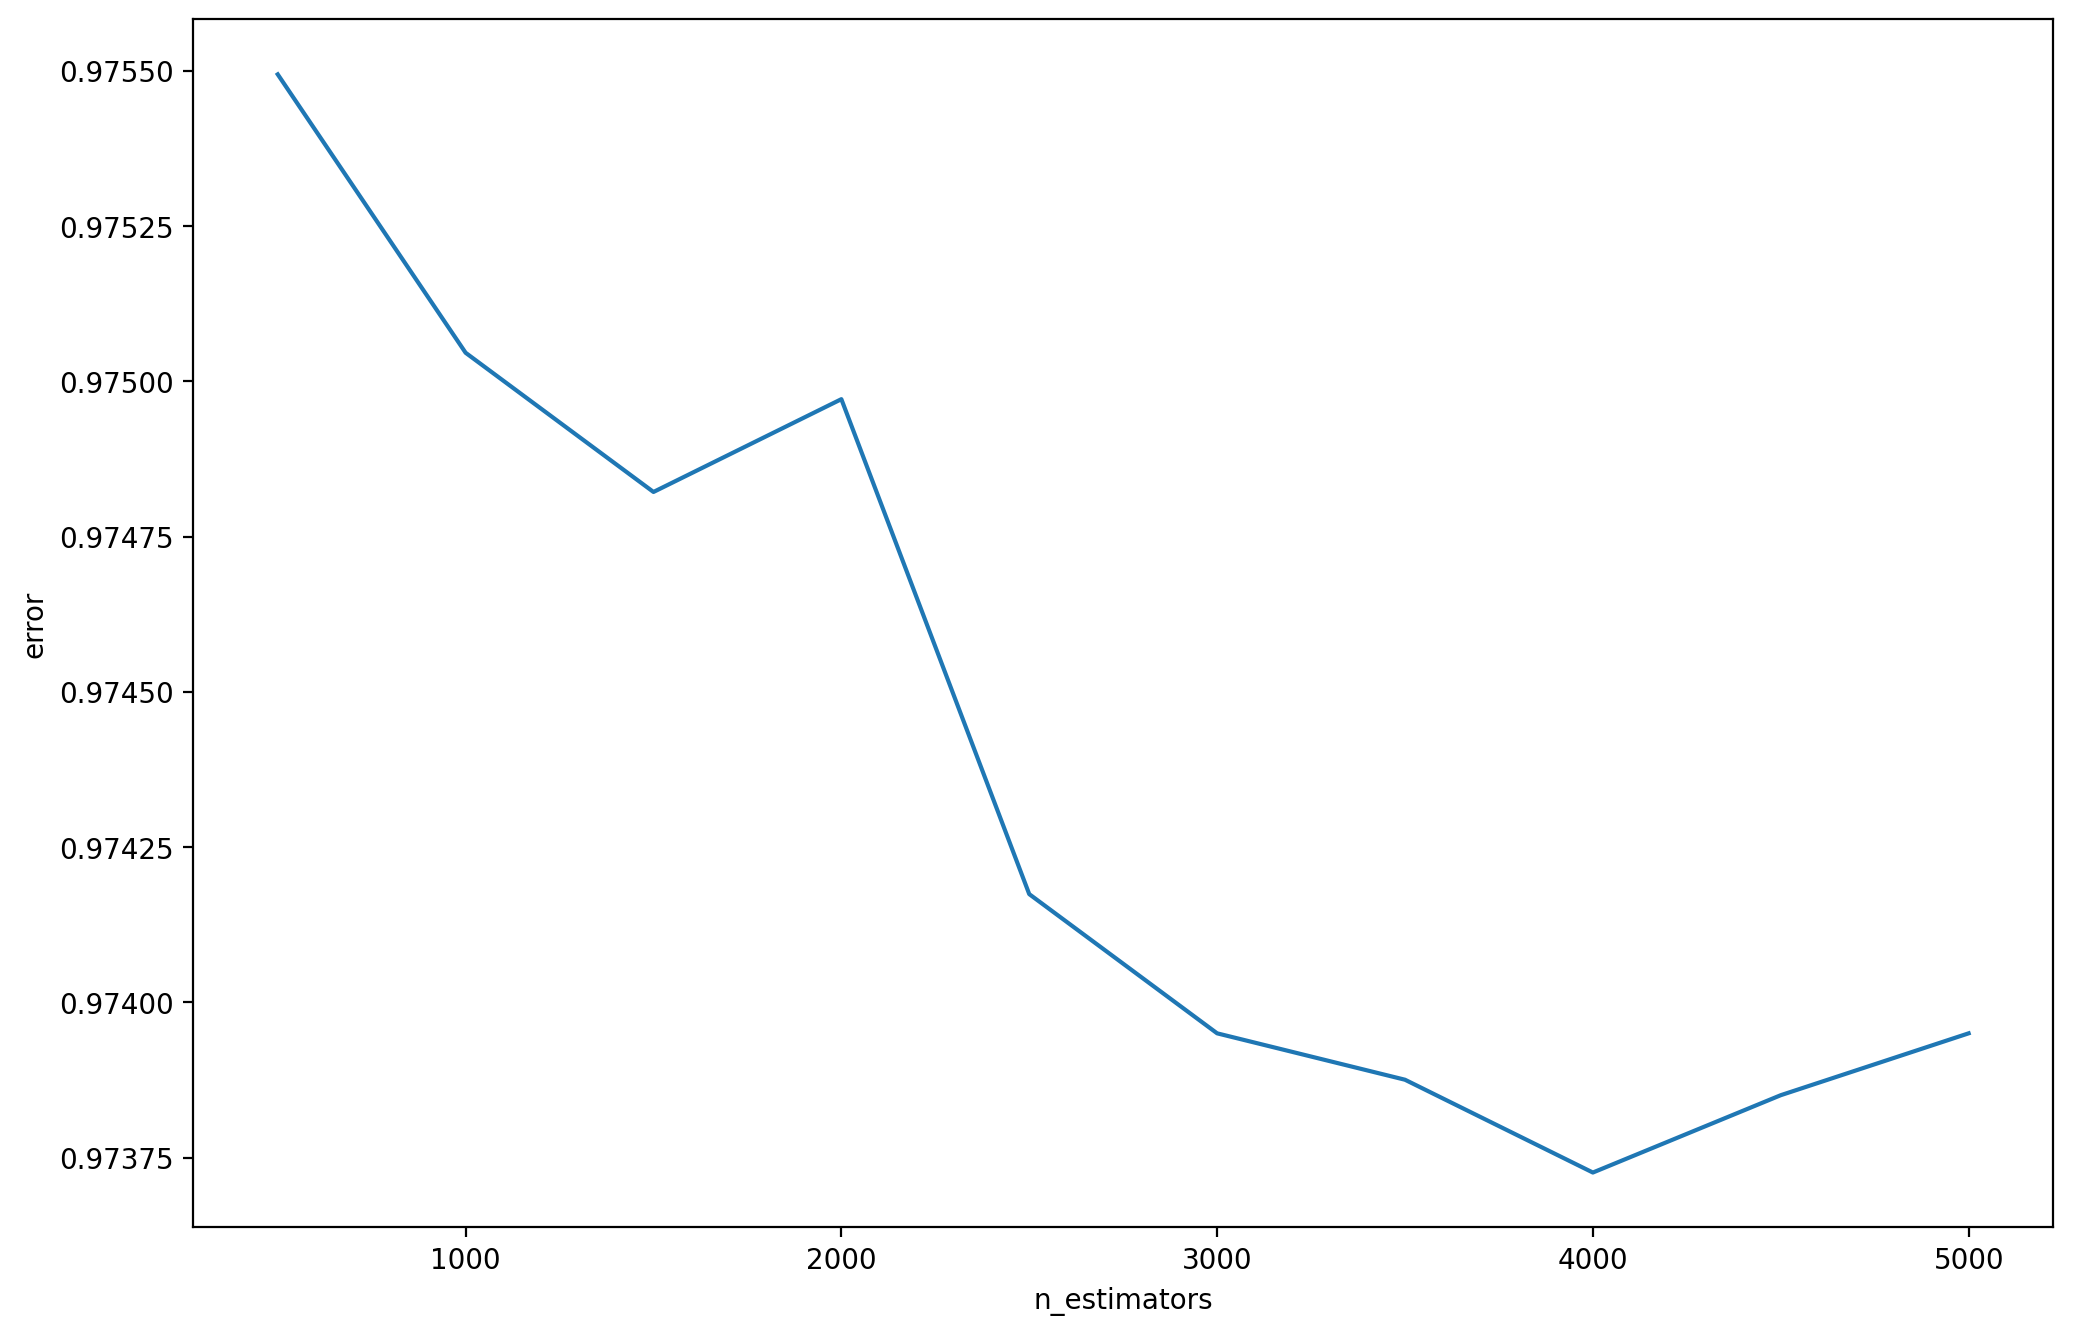

In [64]:
plt.figure(figsize=(12,8), dpi=200)
plt.plot(range(500, 5500, 500), err_plot['error'])
plt.xlabel('n_estimators')
plt.ylabel('error')

In [42]:
model = AdaBoostClassifier(n_estimators=10000, random_state=42)

default learning rate is 1

In [43]:
start=datetime.now()
model.fit(X_train, y_train)
print(datetime.now()-start)

5:59:02.140216


In [44]:
joblib.dump(model, 'AdaBoost.pkl')

['AdaBoost.pkl']

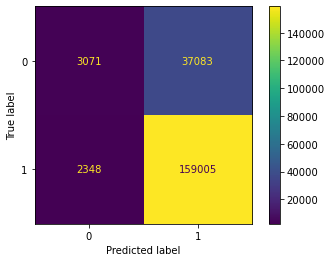

In [45]:
preds = model.predict(X_val)
plot_confusion_matrix(model, X_val, y_val)

In [46]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.57      0.08      0.13     40154
           1       0.81      0.99      0.89    161353

    accuracy                           0.80    201507
   macro avg       0.69      0.53      0.51    201507
weighted avg       0.76      0.80      0.74    201507



In [47]:
1 - recall_score(y_val, preds, pos_label=0)

0.9235194501170494

In [54]:
model.feature_importances_

array([3.840e-02, 4.670e-02, 4.000e-04, 3.349e-01, 1.103e-01, 8.900e-02,
       6.150e-02, 2.400e-03, 8.800e-03, 9.900e-03, 4.600e-03, 1.190e-01,
       6.170e-02, 1.290e-02, 8.800e-03, 1.900e-03, 9.000e-03, 1.000e-03,
       2.200e-03, 3.900e-03, 4.300e-03, 3.600e-03, 3.300e-03, 3.300e-03,
       2.400e-03, 2.000e-03, 1.700e-03, 7.000e-04, 9.000e-04, 9.000e-04,
       1.700e-03, 2.200e-03, 1.900e-03, 2.100e-03, 2.400e-03, 2.500e-03,
       2.200e-03, 2.900e-03, 2.300e-03, 2.200e-03, 2.300e-03, 1.900e-03,
       1.500e-03, 1.600e-03, 1.300e-03, 1.300e-03, 1.000e-03, 8.000e-04,
       6.000e-04, 7.000e-04, 7.000e-04, 1.000e-04, 3.000e-04, 7.000e-04,
       5.000e-04, 4.000e-04, 1.000e-04, 1.200e-03, 9.000e-04, 6.000e-04,
       2.000e-04, 3.000e-04, 1.000e-04, 2.000e-04, 2.000e-04, 1.000e-04,
       2.000e-04, 1.000e-04, 2.000e-04, 2.000e-04, 2.000e-04, 2.000e-04,
       1.000e-04, 1.000e-04, 2.000e-04, 2.000e-04, 1.000e-04, 2.000e-04,
       1.000e-04, 1.000e-04, 2.000e-04, 1.000e-04, 

In [55]:
feat_imp = pd.DataFrame(data=model.feature_importances_, index=X.columns, columns=['importance'])

In [56]:
feat_imp.sort_values('importance', ascending=False)

,importance
int_rate,0.3349
revol_bal,0.1190
installment,0.1103
annual_inc,0.0890
revol_util,0.0617
...,...
MN,0.0001
MO,0.0001
purpose_renewable_energy,0.0001
MT,0.0001


<Figure size 2400x1600 with 0 Axes>

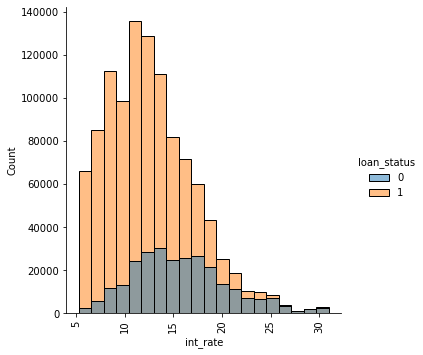

In [47]:
plt.figure(figsize=(12,8), dpi=200)
sns.displot(data=df, x='int_rate', hue='loan_status', bins=20)
plt.xticks(rotation=90);

Let's quadruple the number of estimators to see if it improves performance

In [44]:
model = joblib.load('AdaBoost3.pkl')

I ran this model in another notebook to parallelize the calculations.

In [60]:
model = AdaBoostClassifier(n_estimators=40000, random_state=42, learning_rate=1)

In [ ]:
start=datetime.now()
model.fit(X_train, y_train)
print(datetime.now()-start)
# 16:09:15.171577

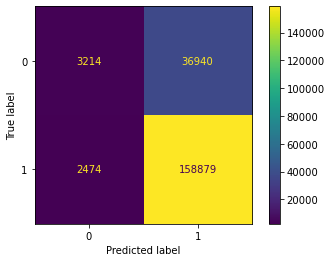

In [45]:
preds = model.predict(X_val)
plot_confusion_matrix(model, X_val, y_val)

In [46]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.57      0.08      0.14     40154
           1       0.81      0.98      0.89    161353

    accuracy                           0.80    201507
   macro avg       0.69      0.53      0.51    201507
weighted avg       0.76      0.80      0.74    201507



In [47]:
1 - recall_score(y_val, preds, pos_label=0)

0.9199581610798426

There isn't much improvement, let's increase the learning rate

In [30]:
model = AdaBoostClassifier(n_estimators=20000, random_state=42, learning_rate=2.0)

In [31]:
start=datetime.now()
model.fit(X_train, y_train)
print(datetime.now()-start)

7:00:00.151597


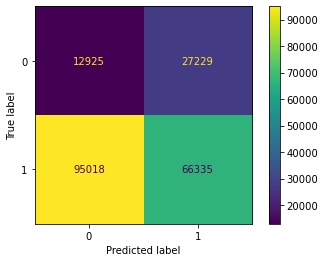

In [32]:
preds = model.predict(X_val)
plot_confusion_matrix(model, X_val, y_val)

In [33]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.12      0.32      0.17     40154
           1       0.71      0.41      0.52    161353

    accuracy                           0.39    201507
   macro avg       0.41      0.37      0.35    201507
weighted avg       0.59      0.39      0.45    201507



In [34]:
1 - recall_score(y_val, preds, pos_label=0)

0.6781142600986203

In [35]:
feat_imp = pd.DataFrame(data=model.feature_importances_, index=X.columns, columns=['importance'])

In [36]:
feat_imp.sort_values('importance', ascending=False)

,importance
int_rate,1.0
loan_amnt,0.0
CT,0.0
MA,0.0
LA,0.0
...,...
E1,0.0
D5,0.0
D4,0.0
D3,0.0


In [37]:
joblib.dump(model, 'AdaBoost.pkl')

['AdaBoost.pkl']

In [143]:
grid = joblib.load('AdaBoost.pkl')
preds = grid.predict(X_val)
results = pd.DataFrame(classification_report(y_val, preds,output_dict=True))
f1 = ['AdaBoost']
for i in np.array(results.loc['f1-score']):
    f1.append(i)
model_results.append(f1)

change the cv results function by removing best estimator as i did not use a grid search for adaboost

In [85]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X.values, y.values, scoring='balanced_accuracy', cv=cv, n_jobs=4, error_score="raise")
    return scores

In [86]:
grid = joblib.load('AdaBoost.pkl')

In [87]:
start=datetime.now()
scores = evaluate_model(grid, X_train, y_train)
print(datetime.now()-start)

1 day, 22:43:51.377391


In [88]:
scores

array([0.36675945, 0.36566611, 0.36513901, 0.36631142, 0.36743329,
       0.36581406, 0.36647743, 0.36552311, 0.36633033, 0.36716435,
       0.3655643 , 0.36617233, 0.36708277, 0.36462216, 0.36786769])

In [89]:
scores_df['AdaBoost'] = scores

In [90]:
scores_df

,logistic_regression,random_forest,AdaBoost
0,0.652997,0.653588,0.366759
1,0.653641,0.652926,0.365666
2,0.653698,0.654439,0.365139
3,0.653548,0.653376,0.366311
4,0.654409,0.652237,0.367433
5,0.652379,0.652978,0.365814
6,0.654146,0.652966,0.366477
7,0.654311,0.653879,0.365523
8,0.653494,0.653196,0.366330
9,0.654074,0.652584,0.367164


In [91]:
joblib.dump(scores_df, 'scores_df_3.pkl')

['scores_df_3.pkl']

Let's try doubling the number of estimators

In [31]:
model = AdaBoostClassifier(n_estimators=40000, random_state=42, learning_rate=2.0)

In [32]:
start=datetime.now()
model.fit(X_train, y_train)
print(datetime.now()-start)

13:48:08.262526


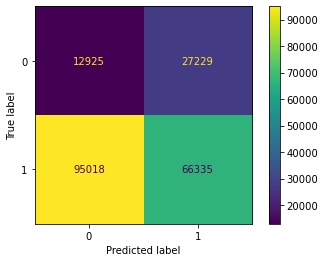

In [33]:
preds = model.predict(X_val)
plot_confusion_matrix(model, X_val, y_val)

In [34]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.12      0.32      0.17     40154
           1       0.71      0.41      0.52    161353

    accuracy                           0.39    201507
   macro avg       0.41      0.37      0.35    201507
weighted avg       0.59      0.39      0.45    201507



In [35]:
1 - recall_score(y_val, preds, pos_label=0)

0.6781142600986203

In [36]:
joblib.dump(model, 'AdaBoost2.pkl')

['AdaBoost2.pkl']

Clearly, the model is overfitting here as the precision error did not budge with twice the number of estimators.

Given the lackluster results from the various attempts for adaboost, I think I should explore other models instead

### Gradient Boosting

In [23]:
model = GradientBoostingClassifier()

In [24]:
param_grid = {'clf__n_estimators': [200],
             'clf__learning_rate' : [1, 2],
             'clf__max_depth': [15],
             'clf__max_features': [20, 25],
             'clf__warm_start' : ['False'],
             'clf__criterion': ['friedman_mse'],
             'clf__random_state' : [42]}

In [25]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clf', model)
                ])

In [26]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', verbose=0, n_jobs=8)

In [27]:
start=datetime.now()
grid.fit(X_train,y_train)
print(datetime.now()-start)

1:34:31.145761


              precision    recall  f1-score   support

           0       0.31      0.23      0.26     40154
           1       0.82      0.87      0.84    161353

    accuracy                           0.74    201507
   macro avg       0.56      0.55      0.55    201507
weighted avg       0.72      0.74      0.73    201507



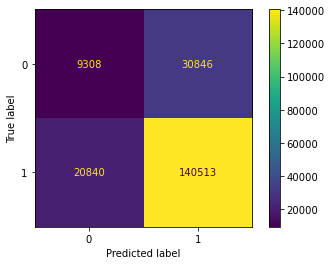

In [28]:
preds = grid.predict(X_val)
plot_confusion_matrix(grid, X_val, y_val)
print(classification_report(y_val, preds))

In [29]:
grid.best_params_

{'clf__criterion': 'friedman_mse',
 'clf__learning_rate': 1,
 'clf__max_depth': 15,
 'clf__max_features': 25,
 'clf__n_estimators': 200,
 'clf__random_state': 42,
 'clf__warm_start': 'False'}

Second grid search, improving upon the first one.

In [38]:
model = GradientBoostingClassifier()

In [39]:
param_grid = {'clf__n_estimators': [200, 300],
             'clf__learning_rate' : [1],
             'clf__max_depth': [15],
             'clf__max_features': [25],
             'clf__loss' : ['deviance', 'exponential'],
             'clf__warm_start' : ['False'],
             'clf__criterion': ['friedman_mse'],
             'clf__random_state' : [42]}

In [40]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clf', model)
                ])

In [41]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', verbose=0, n_jobs=8)

In [42]:
start=datetime.now()
grid.fit(X_train,y_train)
print(datetime.now()-start)

1:56:09.191801


              precision    recall  f1-score   support

           0       0.40      0.17      0.24     40154
           1       0.82      0.94      0.87    161353

    accuracy                           0.78    201507
   macro avg       0.61      0.55      0.56    201507
weighted avg       0.74      0.78      0.75    201507



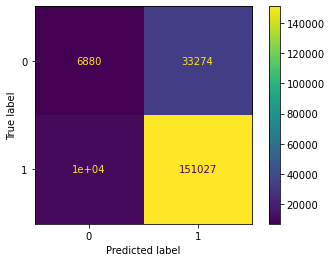

In [43]:
preds = grid.predict(X_val)
plot_confusion_matrix(grid, X_val, y_val)
print(classification_report(y_val, preds))

In [44]:
grid.best_params_

{'clf__criterion': 'friedman_mse',
 'clf__learning_rate': 1,
 'clf__loss': 'exponential',
 'clf__max_depth': 15,
 'clf__max_features': 25,
 'clf__n_estimators': 300,
 'clf__random_state': 42,
 'clf__warm_start': 'False'}

My goal is to maximize true positives, hence, we will rerun the model using 'deviance' instead of exponential although other metrics are giving slightly better performance with exponential

In [45]:
model = GradientBoostingClassifier()

In [46]:
param_grid = {'clf__n_estimators': [300, 400],
             'clf__learning_rate' : [1],
             'clf__max_depth': [15],
             'clf__max_features': [25],
             'clf__loss' : ['deviance'],
             'clf__warm_start' : ['False'],
             'clf__criterion': ['friedman_mse'],
             'clf__random_state' : [42]}

In [47]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clf', model)
                ])

In [48]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', verbose=0, n_jobs=8)

In [49]:
start=datetime.now()
grid.fit(X_train,y_train)
print(datetime.now()-start)

1:16:04.018722


              precision    recall  f1-score   support

           0       0.30      0.24      0.26     40154
           1       0.82      0.86      0.84    161353

    accuracy                           0.74    201507
   macro avg       0.56      0.55      0.55    201507
weighted avg       0.72      0.74      0.73    201507



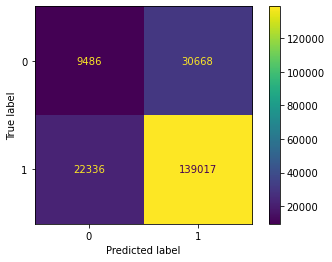

In [50]:
preds = grid.predict(X_val)
plot_confusion_matrix(grid, X_val, y_val)
print(classification_report(y_val, preds))

In [51]:
grid.best_params_

{'clf__criterion': 'friedman_mse',
 'clf__learning_rate': 1,
 'clf__loss': 'deviance',
 'clf__max_depth': 15,
 'clf__max_features': 25,
 'clf__n_estimators': 300,
 'clf__random_state': 42,
 'clf__warm_start': 'False'}

Let's try one more search to see if we can find slightly better hyperparameters

In [23]:
model = GradientBoostingClassifier()

In [24]:
param_grid = {'clf__n_estimators': [300],
             'clf__learning_rate' : [1],
             'clf__max_depth': [15, 18],
             'clf__max_features': [25, 30],
             'clf__subsample' : [1, 0.5],
             'clf__loss' : ['deviance'],
             'clf__warm_start' : ['False'],
             'clf__criterion': ['friedman_mse'],
             'clf__random_state' : [42]}

In [25]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clf', model)
                ])

In [26]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', verbose=0, n_jobs=8)

In [27]:
start=datetime.now()
grid.fit(X_train,y_train)
print(datetime.now()-start)

3:51:09.018224


              precision    recall  f1-score   support

           0       0.31      0.24      0.27     40154
           1       0.82      0.87      0.84    161353

    accuracy                           0.74    201507
   macro avg       0.57      0.55      0.56    201507
weighted avg       0.72      0.74      0.73    201507



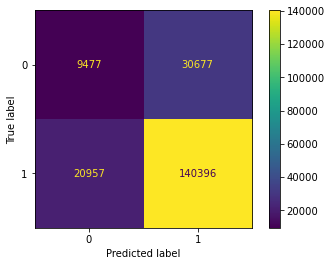

In [28]:
preds = grid.predict(X_val)
plot_confusion_matrix(grid, X_val, y_val)
print(classification_report(y_val, preds))

In [29]:
grid.best_params_

{'clf__criterion': 'friedman_mse',
 'clf__learning_rate': 1,
 'clf__loss': 'deviance',
 'clf__max_depth': 15,
 'clf__max_features': 30,
 'clf__n_estimators': 300,
 'clf__random_state': 42,
 'clf__subsample': 1,
 'clf__warm_start': 'False'}

In [30]:
joblib.dump(grid, 'gradientboosting.pkl')

['gradientboosting.pkl']

In [144]:
grid = joblib.load('gradientboosting.pkl')
preds = grid.predict(X_val)
results = pd.DataFrame(classification_report(y_val, preds,output_dict=True))
f1 = ['gradientboosting']
for i in np.array(results.loc['f1-score']):
    f1.append(i)
model_results.append(f1)

reinitializing the previous function for best estimator

In [92]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    scores = cross_val_score(model.best_estimator_, X.values, y.values, scoring='balanced_accuracy', cv=cv, n_jobs=4, error_score="raise")
    return scores

In [93]:
grid = joblib.load('gradientboosting.pkl')

In [94]:
start=datetime.now()
scores = evaluate_model(grid, X_train, y_train)
print(datetime.now()-start)

2:07:19.668986


In [95]:
scores

array([0.55204412, 0.54630962, 0.54202391, 0.55230694, 0.55067684,
       0.55218501, 0.55225298, 0.55284457, 0.54910845, 0.55243807,
       0.55267993, 0.54947242, 0.55130793, 0.55248267, 0.55200123])

In [96]:
scores_df['gradientboosting'] = scores

In [97]:
scores_df

,logistic_regression,random_forest,AdaBoost,gradientboosting
0,0.652997,0.653588,0.366759,0.552044
1,0.653641,0.652926,0.365666,0.546310
2,0.653698,0.654439,0.365139,0.542024
3,0.653548,0.653376,0.366311,0.552307
4,0.654409,0.652237,0.367433,0.550677
5,0.652379,0.652978,0.365814,0.552185
6,0.654146,0.652966,0.366477,0.552253
7,0.654311,0.653879,0.365523,0.552845
8,0.653494,0.653196,0.366330,0.549108
9,0.654074,0.652584,0.367164,0.552438


In [98]:
joblib.dump(scores_df, 'scores_df_4.pkl')

['scores_df_4.pkl']

## Support Vector Machines|

Let's see if I can reduce the number of dimensions using PCA

In [69]:
model = PCA(n_components=2)

In [70]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('transformer', model)
                ])

In [71]:
model_PCA = pipe.fit_transform(X_train)

In [73]:
model.explained_variance_ratio_

array([0.03359745, 0.0235924 ])

In [80]:
explained_variance = []

for k in range(30,100,10):
    model = PCA(n_components=k)
    pipe = Pipeline([('scaler', StandardScaler()),
                 ('transformer', model)
                ])
    pipe.fit(X_train)
    
    explained_variance.append(np.sum(model.explained_variance_ratio_))

Text(0, 0.5, 'Variance explained')

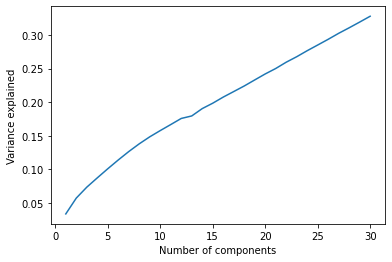

In [76]:
plt.plot(range(1,31), explained_variance)
plt.xlabel('Number of components')
plt.ylabel('Variance explained')

Text(0, 0.5, 'Variance explained')

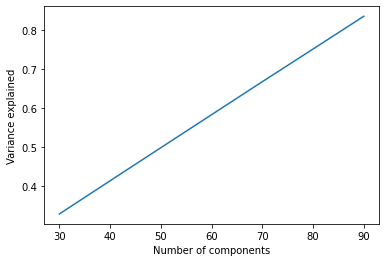

In [82]:
plt.plot(range(30,100,10), explained_variance)
plt.xlabel('Number of components')
plt.ylabel('Variance explained')

In [83]:
explained_variance

[0.32818423869724556,
 0.4133920390813379,
 0.4983789995062964,
 0.5832246859678893,
 0.6679210313460849,
 0.7519113900275651,
 0.8361206620164447]

In [84]:
len(X_train)

940365

At 90 features, the variance explained for the dataset is 83.6 % but this tells me that the dataset does not really have a lot of redudant features. Even reducing to 90 features for a dataset of 940 k rows would prove challenging to use SVM. 

In [87]:
df['loan_status'].value_counts()/len(df)

1    0.800363
0    0.199637
Name: loan_status, dtype: float64

One method to circumvent the large computational cost is to use a random sampling of the training subset to solve the constrained quadratic programming for SVM. The paper below explores this phenomenon.

http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.70.1132&rep=rep1&type=pdf

We will first train our SVC with 10 % of the original dataset and use the train model to make predicts on our validation set to see how the initial SVC model trained with a data subset performs.

In [33]:
df_frac = df.sample(frac=0.1,random_state=42)

In [34]:
df_frac['loan_status'].value_counts()/len(df_frac)

1    0.799409
0    0.200591
Name: loan_status, dtype: float64

In [35]:
len(df_frac)

134338

In [36]:
def _compute_class_weight_dictionary(df):
    # helper for returning a dictionary instead of an array
    classes = np.unique(df['loan_status'])
    class_weight = compute_class_weight("balanced", np.unique(df['loan_status']), np.array(df['loan_status']))
    class_weight_dict = dict(zip(classes, class_weight))
    return class_weight_dict 

In [37]:
weights = _compute_class_weight_dictionary(df)

In [38]:
weights

{0: 2.5045471833191644, 1: 0.6247164457291774}

In [39]:
X_frac = df_frac.drop('loan_status', axis=1)
y_frac = df_frac['loan_status']

In [40]:
X_train_frac, X_test_frac, y_train_frac, y_test_frac = train_test_split(X_frac, y_frac, test_size=0.30, random_state=42)

In [41]:
X_val_frac, X_test_frac, y_val_frac, y_test_frac = train_test_split(X_test_frac, y_test_frac, test_size=0.50, random_state=42)

In [42]:
len(X_train_frac)

94036

In [43]:
len(X_val_frac)

20151

In [44]:
len(X_test_frac)

20151

In [40]:
model = SVC()

In [41]:
param_grid = {'clf__C' : [1],
             'clf__kernel' : ['rbf', 'linear'],
             'clf__gamma' : ['scale', 'auto'],
             'clf__class_weight' : [weights],
             'clf__max_iter' : [-1],
             'clf__random_state' : [42],
             'clf__verbose' : [1]}

In [42]:
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('clf', model)
                ])

In [43]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='balanced_accuracy', verbose=2, n_jobs=8)

In [44]:
start=datetime.now()
grid.fit(X_train_frac,y_train_frac)
print(datetime.now()-start)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LibSVM]3:34:09.080041


              precision    recall  f1-score   support

           0       0.31      0.67      0.42      4037
           1       0.88      0.62      0.73     16114

    accuracy                           0.63     20151
   macro avg       0.60      0.65      0.58     20151
weighted avg       0.77      0.63      0.67     20151



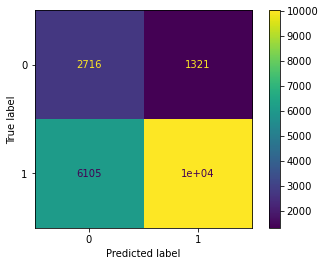

In [45]:
preds = grid.predict(X_val_frac)
plot_confusion_matrix(grid, X_val_frac, y_val_frac)
print(classification_report(y_val_frac, preds))

In [46]:
grid.best_params_

{'clf__C': 1,
 'clf__class_weight': {0: 2.5045471833191644, 1: 0.6247164457291774},
 'clf__gamma': 'scale',
 'clf__kernel': 'rbf',
 'clf__max_iter': -1,
 'clf__random_state': 42,
 'clf__verbose': 1}

In [47]:
joblib.dump(grid, 'SVM1.pkl')

['SVM1.pkl']

Applying our SVC trained on 10 % of the dataset to our validation set

In [48]:
preds = grid.predict(X_val)

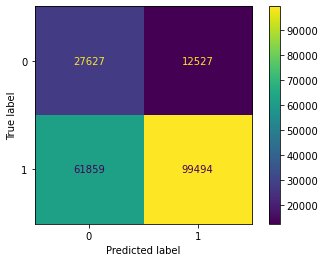

In [49]:
plot_confusion_matrix(grid, X_val, y_val)

In [50]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.31      0.69      0.43     40154
           1       0.89      0.62      0.73    161353

    accuracy                           0.63    201507
   macro avg       0.60      0.65      0.58    201507
weighted avg       0.77      0.63      0.67    201507



This is a really good preliminary result given that svc was only train on 10 % of the original dataset. In fact, it out performs our random forest model for label 0 recall and gives true positive predictions comparable with our logistic model.

We will expand our grid search with varying strength of regularization to find the best set of parameters for our SVC. We will then increase the size of the dataset train on with out optimized parameter set for 10 % of the dataset until the computational cost becomes untenable.

In [51]:
model = SVC()

In [52]:
param_grid = {'clf__C' : [1, 0.1, 0.001, 0.0001],
             'clf__kernel' : ['rbf'],
             'clf__gamma' : ['scale'],
             'clf__class_weight' : [weights],
             'clf__max_iter' : [-1],
             'clf__random_state' : [42],
             'clf__verbose' : [1]}

In [53]:
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('clf', model)
                ])

In [54]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='balanced_accuracy', verbose=2, n_jobs=8)

In [55]:
start=datetime.now()
grid.fit(X_train_frac,y_train_frac)
print(datetime.now()-start)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LibSVM]3:13:57.657877


              precision    recall  f1-score   support

           0       0.31      0.67      0.42      4037
           1       0.88      0.62      0.73     16114

    accuracy                           0.63     20151
   macro avg       0.60      0.65      0.58     20151
weighted avg       0.77      0.63      0.67     20151



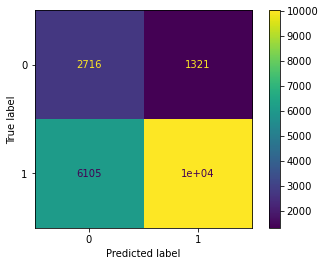

In [56]:
preds = grid.predict(X_val_frac)
plot_confusion_matrix(grid, X_val_frac, y_val_frac)
print(classification_report(y_val_frac, preds))

In [57]:
grid.best_params_

{'clf__C': 1,
 'clf__class_weight': {0: 2.5045471833191644, 1: 0.6247164457291774},
 'clf__gamma': 'scale',
 'clf__kernel': 'rbf',
 'clf__max_iter': -1,
 'clf__random_state': 42,
 'clf__verbose': 1}

Since our grid search came back with the same set of parameters as our original test, we will search again with decreasing regularization strength

In [46]:
model = SVC()

In [47]:
param_grid = {'clf__C' : [1, 10, 100, 1000],
             'clf__kernel' : ['rbf'],
             'clf__gamma' : ['scale'],
             'clf__class_weight' : [weights],
             'clf__max_iter' : [-1],
             'clf__random_state' : [42],
             'clf__verbose' : [1]}

In [48]:
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('clf', model)
                ])

In [49]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='balanced_accuracy', verbose=2, n_jobs=8)

In [50]:
start=datetime.now()
grid.fit(X_train_frac,y_train_frac)
print(datetime.now()-start)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LibSVM]1 day, 14:45:44.374427


              precision    recall  f1-score   support

           0       0.31      0.67      0.42      4037
           1       0.88      0.62      0.73     16114

    accuracy                           0.63     20151
   macro avg       0.60      0.65      0.58     20151
weighted avg       0.77      0.63      0.67     20151



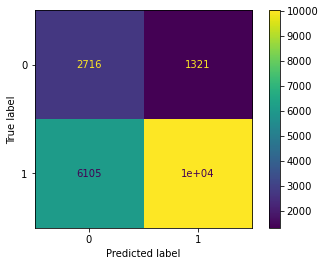

In [51]:
preds = grid.predict(X_val_frac)
plot_confusion_matrix(grid, X_val_frac, y_val_frac)
print(classification_report(y_val_frac, preds))

In [52]:
joblib.dump(grid, 'SVM2.pkl')

['SVM2.pkl']

              precision    recall  f1-score   support

           0       0.31      0.69      0.43     40154
           1       0.89      0.62      0.73    161353

    accuracy                           0.63    201507
   macro avg       0.60      0.65      0.58    201507
weighted avg       0.77      0.63      0.67    201507



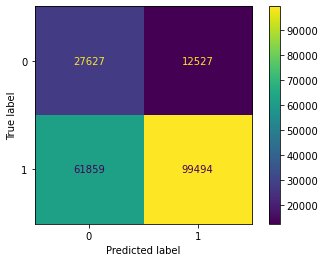

In [53]:
preds = grid.predict(X_val)
plot_confusion_matrix(grid, X_val, y_val)
print(classification_report(y_val, preds))

In [61]:
svm_10percent_cv_results = pd.DataFrame(grid.cv_results_)

In [62]:
svm_10percent_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__class_weight,param_clf__gamma,param_clf__kernel,param_clf__max_iter,param_clf__random_state,param_clf__verbose,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1820.072454,47.625299,272.381749,2.365869,1,"{0: 2.5045471833191644, 1: 0.6247164457291774}",scale,rbf,-1,42,1,"{'clf__C': 1, 'clf__class_weight': {0: 2.50454...",0.647217,0.639682,0.647218,0.649139,0.644028,0.645457,0.003321,1
1,3678.728984,118.291202,290.339233,5.144213,10,"{0: 2.5045471833191644, 1: 0.6247164457291774}",scale,rbf,-1,42,1,"{'clf__C': 10, 'clf__class_weight': {0: 2.5045...",0.616143,0.609769,0.603783,0.611607,0.608464,0.609953,0.004034,2
2,18157.576103,401.602260,240.361200,17.989866,100,"{0: 2.5045471833191644, 1: 0.6247164457291774}",scale,rbf,-1,42,1,"{'clf__C': 100, 'clf__class_weight': {0: 2.504...",0.574784,0.570919,0.563325,0.571016,0.571895,0.570388,0.003799,3
3,70785.727457,26862.258490,688.618365,23.749977,1000,"{0: 2.5045471833191644, 1: 0.6247164457291774}",scale,rbf,-1,42,1,"{'clf__C': 1000, 'clf__class_weight': {0: 2.50...",0.549244,0.553137,0.551690,0.551386,0.553799,0.551851,0.001580,4


In [58]:
grid.best_params_

{'clf__C': 1,
 'clf__class_weight': {0: 2.5045471833191644, 1: 0.6247164457291774},
 'clf__gamma': 'scale',
 'clf__kernel': 'rbf',
 'clf__max_iter': -1,
 'clf__random_state': 42,
 'clf__verbose': 1}

In [63]:
joblib.dump(svm_10percent_cv_results, 'svm_10percent_cv_results.pkl')

['svm_10percent_cv_results.pkl']

In [67]:
joblib.dump(grid.best_params_, 'svm_10percent_grid_best_params.pkl')

['svm_10percent_grid_best_params.pkl']

In [66]:
# test = joblib.load('svm_10percent_cv_results.pkl')

NOTE: Increasing training set size

In [68]:
def _compute_class_weight_dictionary(df):
    # helper for returning a dictionary instead of an array
    classes = np.unique(df['loan_status'])
    class_weight = compute_class_weight("balanced", np.unique(df['loan_status']), np.array(df['loan_status']))
    class_weight_dict = dict(zip(classes, class_weight))
    return class_weight_dict 

In [69]:
weights = _compute_class_weight_dictionary(df)

C:\Users\kaile\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 0 1 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [87]:
df_frac_20 = df.sample(frac=0.2,random_state=42)

In [88]:
X_20 = df_frac_20.drop('loan_status', axis=1)
y_20 = df_frac_20['loan_status']

In [89]:
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X_20, y_20, test_size=0.30, random_state=42)

In [90]:
X_val_20, X_test_20, y_val_20, y_test_20 = train_test_split(X_test_20, y_test_20, test_size=0.50, random_state=42)

In [91]:
model = SVC()

In [92]:
param_grid = {'clf__C' : [1],
             'clf__kernel' : ['rbf'],
             'clf__gamma' : ['scale'],
             'clf__class_weight' : [weights],
             'clf__max_iter' : [-1],
             'clf__random_state' : [42],
             'clf__verbose' : [1]}

In [93]:
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('clf', model)
                ])

In [94]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='balanced_accuracy', verbose=2, n_jobs=8)

In [95]:
start=datetime.now()
grid.fit(X_train_20, y_train_20)
print(datetime.now()-start)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibSVM]3:21:27.750080


              precision    recall  f1-score   support

           0       0.31      0.68      0.42      8028
           1       0.89      0.62      0.73     32273

    accuracy                           0.63     40301
   macro avg       0.60      0.65      0.57     40301
weighted avg       0.77      0.63      0.67     40301



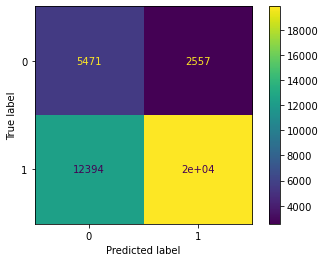

In [96]:
preds = grid.predict(X_val_20)
plot_confusion_matrix(grid, X_val_20, y_val_20)
print(classification_report(y_val_20, preds))

              precision    recall  f1-score   support

           0       0.31      0.70      0.43     40154
           1       0.89      0.62      0.73    161353

    accuracy                           0.63    201507
   macro avg       0.60      0.66      0.58    201507
weighted avg       0.78      0.63      0.67    201507



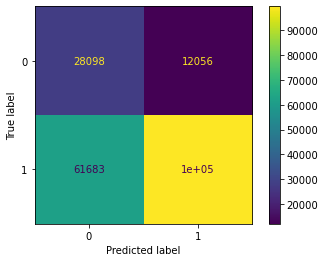

In [97]:
preds = grid.predict(X_val)
plot_confusion_matrix(grid, X_val, y_val)
print(classification_report(y_val, preds))

I could increase the training dataset beyond 20 percent. However, given the massive increase in computational cost, the limitations of my hardware and the expected slight improvement in performance; instead, for SVM, a training subset of 20 percent of the dataset is satisfactory for this model.

In [98]:
joblib.dump(grid, 'SVM_20pc.pkl')

['SVM_20pc.pkl']

In [99]:
svm_20pc_cv_results = pd.DataFrame(grid.cv_results_)

In [100]:
joblib.dump(svm_20pc_cv_results, 'svm_20pc_cv_results.pkl')

['svm_20pc_cv_results.pkl']

In [101]:
joblib.dump(grid.best_params_, 'svm_20pc_grid_best_params.pkl')

['svm_20pc_grid_best_params.pkl']

In [145]:
grid = joblib.load('SVM_20pc.pkl')
preds = grid.predict(X_val)
results = pd.DataFrame(classification_report(y_val, preds,output_dict=True))
f1 = ['SVM_20pc_df']
for i in np.array(results.loc['f1-score']):
    f1.append(i)
model_results.append(f1)

In [99]:
grid = joblib.load('SVM_20pc.pkl')

In [100]:
start=datetime.now()
scores = evaluate_model(grid, X_train, y_train)
print(datetime.now()-start)

6 days, 12:29:22.138054


In [101]:
scores

array([0.6490657 , 0.64867267, 0.64948184, 0.64905866, 0.64949104,
       0.6482014 , 0.6487567 , 0.64905505, 0.64902448, 0.64829873,
       0.64967627, 0.64781345, 0.64826183, 0.64979748, 0.64960299])

In [102]:
scores_df['svm_20pc_df'] = scores

In [103]:
scores_df

,logistic_regression,random_forest,AdaBoost,gradientboosting,svm_20pc_df
0,0.652997,0.653588,0.366759,0.552044,0.649066
1,0.653641,0.652926,0.365666,0.546310,0.648673
2,0.653698,0.654439,0.365139,0.542024,0.649482
3,0.653548,0.653376,0.366311,0.552307,0.649059
4,0.654409,0.652237,0.367433,0.550677,0.649491
5,0.652379,0.652978,0.365814,0.552185,0.648201
6,0.654146,0.652966,0.366477,0.552253,0.648757
7,0.654311,0.653879,0.365523,0.552845,0.649055
8,0.653494,0.653196,0.366330,0.549108,0.649024
9,0.654074,0.652584,0.367164,0.552438,0.648299


In [104]:
joblib.dump(scores_df, 'scores_df_5.pkl')

['scores_df_5.pkl']

## Gaussian Naive Bayes

In [178]:
model = GaussianNB()

In [179]:
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('clf', model)
                ])

In [180]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('clf', GaussianNB())])

              precision    recall  f1-score   support

           0       0.35      0.40      0.37     40154
           1       0.85      0.82      0.83    161353

    accuracy                           0.73    201507
   macro avg       0.60      0.61      0.60    201507
weighted avg       0.75      0.73      0.74    201507



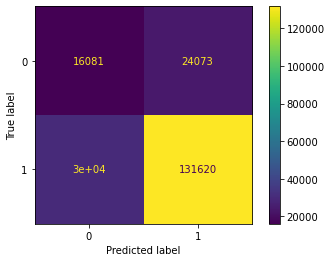

In [181]:
preds = pipe.predict(X_val)
plot_confusion_matrix(pipe, X_val, y_val)
print(classification_report(y_val, preds))

In [182]:
joblib.dump(pipe, 'gaussian_naive_bayes.pkl')

['gaussian_naive_bayes.pkl']

In [183]:
grid = joblib.load('gaussian_naive_bayes.pkl')
preds = grid.predict(X_val)
results = pd.DataFrame(classification_report(y_val, preds,output_dict=True))
f1 = ['gaussian_naive_bayes']
for i in np.array(results.loc['f1-score']):
    f1.append(i)
model_results.append(f1)

removing best estimator from cv function

In [105]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X.values, y.values, scoring='balanced_accuracy', cv=cv, n_jobs=4, error_score="raise")
    return scores

In [106]:
grid = joblib.load('gaussian_naive_bayes.pkl')

In [107]:
start=datetime.now()
scores = evaluate_model(grid, X_train, y_train)
print(datetime.now()-start)

0:00:17.160204


In [108]:
scores

array([0.60797923, 0.60815739, 0.60576592, 0.63299904, 0.60746983,
       0.60766508, 0.60810514, 0.60820365, 0.60665342, 0.63214063,
       0.63026373, 0.60626698, 0.60961395, 0.60888534, 0.60605461])

In [109]:
scores_df['gaussian_nb'] = scores

In [110]:
scores_df

,logistic_regression,random_forest,AdaBoost,gradientboosting,svm_20pc_df,gaussian_nb
0,0.652997,0.653588,0.366759,0.552044,0.649066,0.607979
1,0.653641,0.652926,0.365666,0.546310,0.648673,0.608157
2,0.653698,0.654439,0.365139,0.542024,0.649482,0.605766
3,0.653548,0.653376,0.366311,0.552307,0.649059,0.632999
4,0.654409,0.652237,0.367433,0.550677,0.649491,0.607470
5,0.652379,0.652978,0.365814,0.552185,0.648201,0.607665
6,0.654146,0.652966,0.366477,0.552253,0.648757,0.608105
7,0.654311,0.653879,0.365523,0.552845,0.649055,0.608204
8,0.653494,0.653196,0.366330,0.549108,0.649024,0.606653
9,0.654074,0.652584,0.367164,0.552438,0.648299,0.632141


In [111]:
joblib.dump(scores_df, 'scores_df_6.pkl')

['scores_df_6.pkl']

## K Nearest Neighbors (KNN)

KNN was run on another notebook to parallelize the calculations

The commands from the other notebook is copied over and the outputs are loaded in

In [27]:
model = joblib.load('knn.pkl')

In [28]:
knn_cv_results = joblib.load('knn_cv_results.pkl')

In [29]:
knn_best_params = joblib.load('knn_grid_best_params.pkl')

commands begin

In [ ]:
model = KNeighborsClassifier()

In [ ]:
k_values = list(range(2, 32, 2))

In [ ]:
k_values

In [ ]:
param_grid = {'clf__n_neighbors': k_values,
             'clf__n_jobs' : [12]}

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clf', model)
                ])

In [ ]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='balanced_accuracy', verbose=2, n_jobs=8)

In [ ]:
start=datetime.now()
grid.fit(X_train, y_train)
print(datetime.now()-start)
#Fitting 5 folds for each of 15 candidates, totalling 75 fits
#1 day, 6:18:48.925741

In [ ]:
knn_cv_results = pd.Series(grid.cv_results_)

In [ ]:
plt.plot(k_values, knn_cv_results['mean_test_score'], 'o-')

In [ ]:
preds = grid.predict(X_val)
plot_confusion_matrix(grid, X_val, y_val)
print(classification_report(y_val, preds))

In [ ]:
knn_cv_results = pd.DataFrame(grid.cv_results_)

commands end

              precision    recall  f1-score   support

           0       0.27      0.46      0.34     40154
           1       0.84      0.69      0.76    161353

    accuracy                           0.64    201507
   macro avg       0.55      0.57      0.55    201507
weighted avg       0.72      0.64      0.67    201507



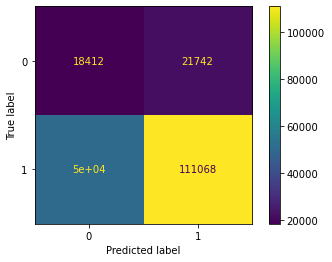

In [30]:
preds = model.predict(X_val)
plot_confusion_matrix(model, X_val, y_val)
print(classification_report(y_val, preds))

In [31]:
k_values = list(range(2, 32, 2))

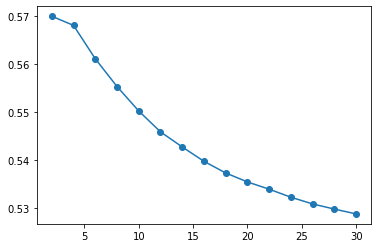

In [32]:
plt.plot(k_values, knn_cv_results['mean_test_score'], 'o-')

In [146]:
grid = joblib.load('knn.pkl')
preds = grid.predict(X_val)
results = pd.DataFrame(classification_report(y_val, preds,output_dict=True))
f1 = ['knn']
for i in np.array(results.loc['f1-score']):
    f1.append(i)
model_results.append(f1)

In [112]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    scores = cross_val_score(model.best_estimator_, X.values, y.values, scoring='balanced_accuracy', cv=cv, n_jobs=4, error_score="raise")
    return scores

In [113]:
grid = joblib.load('knn.pkl')

In [114]:
start=datetime.now()
scores = evaluate_model(grid, X_train, y_train)
print(datetime.now()-start)

4:55:35.736137


In [115]:
scores

array([0.5716842 , 0.56997376, 0.56981869, 0.57140084, 0.56838782,
       0.57183582, 0.5677731 , 0.57126709, 0.57062389, 0.57192802,
       0.57092734, 0.57000966, 0.57042412, 0.57004671, 0.56929368])

In [116]:
scores_df['knn'] = scores

In [117]:
scores_df

,logistic_regression,random_forest,AdaBoost,gradientboosting,svm_20pc_df,gaussian_nb,knn
0,0.652997,0.653588,0.366759,0.552044,0.649066,0.607979,0.571684
1,0.653641,0.652926,0.365666,0.546310,0.648673,0.608157,0.569974
2,0.653698,0.654439,0.365139,0.542024,0.649482,0.605766,0.569819
3,0.653548,0.653376,0.366311,0.552307,0.649059,0.632999,0.571401
4,0.654409,0.652237,0.367433,0.550677,0.649491,0.607470,0.568388
5,0.652379,0.652978,0.365814,0.552185,0.648201,0.607665,0.571836
6,0.654146,0.652966,0.366477,0.552253,0.648757,0.608105,0.567773
7,0.654311,0.653879,0.365523,0.552845,0.649055,0.608204,0.571267
8,0.653494,0.653196,0.366330,0.549108,0.649024,0.606653,0.570624
9,0.654074,0.652584,0.367164,0.552438,0.648299,0.632141,0.571928


In [118]:
joblib.dump(scores_df, 'scores_df_7.pkl')

['scores_df_7.pkl']

## Artificial Neural Network (ANN)

ANN setup

In [23]:
def _compute_class_weight_dictionary(df):
    # helper for returning a dictionary instead of an array
    classes = np.unique(df['loan_status'])
    class_weight = compute_class_weight("balanced", np.unique(df['loan_status']), np.array(df['loan_status']))
    class_weight_dict = dict(zip(classes, class_weight))
    return class_weight_dict 

In [24]:
weights = _compute_class_weight_dictionary(df)

C:\Users\kaile\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 0 1 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [25]:
scaler = MinMaxScaler()

In [26]:
scaled_X_train = scaler.fit_transform(X_train)

In [27]:
scaled_X_val = scaler.transform(X_val)

Let's try a simple 121_121_121 network first

In [114]:
model = Sequential()

model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

In [115]:
model.fit(x=scaled_X_train, 
          y=y_train, 
          epochs=2000,
          batch_size=256,
      )

Epoch 1/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4570
Epoch 2/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4531
Epoch 3/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4519
Epoch 4/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4510
Epoch 5/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4502
Epoch 6/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4495
Epoch 7/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4489
Epoch 8/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4481
Epoch 9/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4475
Epoch 10/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4468
Epoch 11/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4460
Epoch 12/2000
3674/3674 [==============================] - 5s 1

3674/3674 [==============================] - 5s 1ms/step - loss: 0.3987A: 0s - loss
Epoch 191/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3987
Epoch 192/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3986
Epoch 193/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3984
Epoch 194/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3983
Epoch 195/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3981
Epoch 196/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3982
Epoch 197/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3980
Epoch 198/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3981
Epoch 199/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3977
Epoch 200/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3979
Epoch 201/2000
3674/3674 [====================

3674/3674 [==============================] - 5s 1ms/step - loss: 0.3893
Epoch 379/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.3896
Epoch 380/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.3894
Epoch 381/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.3897
Epoch 382/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.3893
Epoch 383/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.3893
Epoch 384/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.3895
Epoch 385/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3892
Epoch 386/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3892
Epoch 387/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3893
Epoch 388/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3891
Epoch 389/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 4s 1ms/step - loss: 0.3851
Epoch 567/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.3849
Epoch 568/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.3851
Epoch 569/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3849
Epoch 570/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3847
Epoch 571/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3851
Epoch 572/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3849
Epoch 573/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3849
Epoch 574/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3849
Epoch 575/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3850
Epoch 576/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3849
Epoch 577/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 5s 1ms/step - loss: 0.3824
Epoch 755/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3820
Epoch 756/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3823
Epoch 757/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3822
Epoch 758/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3822
Epoch 759/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3822
Epoch 760/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3823
Epoch 761/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3824
Epoch 762/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3823
Epoch 763/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3820
Epoch 764/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3823
Epoch 765/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 5s 1ms/step - loss: 0.3805
Epoch 943/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3808
Epoch 944/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3806
Epoch 945/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3807
Epoch 946/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3807
Epoch 947/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3808
Epoch 948/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3806
Epoch 949/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3805
Epoch 950/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3806
Epoch 951/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3803
Epoch 952/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3808
Epoch 953/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 5s 1ms/step - loss: 0.3798
Epoch 1129/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3795
Epoch 1130/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3795
Epoch 1131/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3796
Epoch 1132/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3791
Epoch 1133/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3794
Epoch 1134/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3793
Epoch 1135/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3798
Epoch 1136/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3791
Epoch 1137/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3797
Epoch 1138/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3794
Epoch 1139/2000
3674/3674 [=====================

3674/3674 [==============================] - 5s 1ms/step - loss: 0.3786
Epoch 1315/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3784
Epoch 1316/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3787
Epoch 1317/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3783
Epoch 1318/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3785
Epoch 1319/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3787
Epoch 1320/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3786
Epoch 1321/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3786
Epoch 1322/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3787
Epoch 1323/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3785
Epoch 1324/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3785
Epoch 1325/2000
3674/3674 [=====================

3674/3674 [==============================] - 5s 1ms/step - loss: 0.3782
Epoch 1408/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3784
Epoch 1409/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3782
Epoch 1410/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3783
Epoch 1411/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3784
Epoch 1412/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3783
Epoch 1413/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3781
Epoch 1414/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3780
Epoch 1415/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3782
Epoch 1416/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3782
Epoch 1417/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3782
Epoch 1418/2000
3674/3674 [=====================

3674/3674 [==============================] - 5s 1ms/step - loss: 0.3775
Epoch 1594/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3775
Epoch 1595/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3777
Epoch 1596/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3781
Epoch 1597/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3774
Epoch 1598/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3775
Epoch 1599/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3781
Epoch 1600/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3774
Epoch 1601/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3781
Epoch 1602/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3775
Epoch 1603/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3775
Epoch 1604/2000
3674/3674 [=====================

3674/3674 [==============================] - 5s 1ms/step - loss: 0.3768
Epoch 1780/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3771
Epoch 1781/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3768
Epoch 1782/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3769
Epoch 1783/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3777
Epoch 1784/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3771
Epoch 1785/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3769
Epoch 1786/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3776
Epoch 1787/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3772
Epoch 1788/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.3769
Epoch 1789/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.3773
Epoch 1790/2000
3674/3674 [=====================

3674/3674 [==============================] - 5s 1ms/step - loss: 0.3767
Epoch 1966/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3771
Epoch 1967/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3763
Epoch 1968/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3771
Epoch 1969/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3765
Epoch 1970/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3771
Epoch 1971/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.3768
Epoch 1972/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.3774
Epoch 1973/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.3773
Epoch 1974/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.3762
Epoch 1975/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.3767
Epoch 1976/2000
3674/3674 [=====================

<AxesSubplot:>

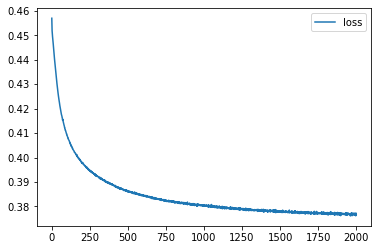

In [116]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [117]:
y_pred = model.predict(scaled_X_val)
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.
print(classification_report(y_val, y_pred))
confusion_matrix(y_val, y_pred)

              precision    recall  f1-score   support

           0       0.38      0.14      0.20     40154
           1       0.82      0.94      0.87    161353

    accuracy                           0.78    201507
   macro avg       0.60      0.54      0.54    201507
weighted avg       0.73      0.78      0.74    201507



array([[  5597,  34557],
       [  9107, 152246]], dtype=int64)

This is a poor performance. Now let's account for class imbalance and run it overnight. It will overfit but it will give me a good idea where to stop training for future models. (I tried using early stop loss but it stops the training after 6-7 epochs where the model is no where close to being trained, perhaps I could use a much larger patience but the following trial and error method works quite well too)

In [108]:
model = Sequential()

model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

In [109]:
model.fit(x=scaled_X_train, 
          y=y_train, 
          epochs=10000,
          batch_size=256,
          class_weight=weights
      )

Epoch 1/10000
3674/3674 [==============================] - 6s 1ms/step - loss: 0.6251
Epoch 2/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6202
Epoch 3/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6184
Epoch 4/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6169
Epoch 5/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6155
Epoch 6/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6146
Epoch 7/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6133
Epoch 8/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6122
Epoch 9/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6109
Epoch 10/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6098
Epoch 11/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.6085
Epoch 12/10000
3674/3674 [==========================

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5516
Epoch 96/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5508
Epoch 97/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5507
Epoch 98/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5503
Epoch 99/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5500
Epoch 100/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5500
Epoch 101/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5497
Epoch 102/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5495
Epoch 103/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5492
Epoch 104/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5490
Epoch 105/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5485
Epoch 106/10000
3674/3674 [=========================

Epoch 281/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5268
Epoch 282/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5265
Epoch 283/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5264
Epoch 284/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5269
Epoch 285/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5264
Epoch 286/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5261
Epoch 287/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5264
Epoch 288/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5261
Epoch 289/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5266
Epoch 290/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5264
Epoch 291/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5259
Epoch 292/10000
3674/3674 [=====

Epoch 374/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5221
Epoch 375/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5219
Epoch 376/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5218
Epoch 377/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5221
Epoch 378/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5218
Epoch 379/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5219
Epoch 380/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5220
Epoch 381/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5214
Epoch 382/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5216
Epoch 383/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5215
Epoch 384/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5219
Epoch 385/10000
3674/3674 [=====

3674/3674 [==============================] - 4s 1ms/step - loss: 0.5172
Epoch 560/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5175
Epoch 561/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5173
Epoch 562/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5172
Epoch 563/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5172
Epoch 564/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5174
Epoch 565/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5172
Epoch 566/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5168
Epoch 567/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5168
Epoch 568/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5173
Epoch 569/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5173
Epoch 570/10000
3674/3674 [=====================

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5147
Epoch 746/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5149
Epoch 747/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5145
Epoch 748/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5150
Epoch 749/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5150
Epoch 750/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5151
Epoch 751/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5149
Epoch 752/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5150
Epoch 753/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5149
Epoch 754/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5148
Epoch 755/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5146
Epoch 756/10000
3674/3674 [=====================

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5136
Epoch 932/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5135
Epoch 933/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5138
Epoch 934/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5141
Epoch 935/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5137
Epoch 936/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5132
Epoch 937/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5137
Epoch 938/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5134
Epoch 939/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5137
Epoch 940/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5140
Epoch 941/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5135
Epoch 942/10000
3674/3674 [=====================

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5138
Epoch 1025/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5135
Epoch 1026/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5137
Epoch 1027/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5134
Epoch 1028/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5136
Epoch 1029/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5133
Epoch 1030/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5132
Epoch 1031/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5137
Epoch 1032/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5140
Epoch 1033/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5136
Epoch 1034/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5139
Epoch 1035/10000
3674/3674 [==========

3674/3674 [==============================] - 4s 1ms/step - loss: 0.5137
Epoch 1209/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5139
Epoch 1210/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5137
Epoch 1211/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5141
Epoch 1212/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5135
Epoch 1213/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5137
Epoch 1214/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5139
Epoch 1215/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5140
Epoch 1216/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5138
Epoch 1217/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5135
Epoch 1218/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5135
Epoch 1219/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5146
Epoch 1393/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5143
Epoch 1394/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5136
Epoch 1395/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5146
Epoch 1396/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5140
Epoch 1397/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5138
Epoch 1398/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5143
Epoch 1399/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5144
Epoch 1400/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5142
Epoch 1401/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5145
Epoch 1402/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5139
Epoch 1403/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5155
Epoch 1577/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5156
Epoch 1578/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5152
Epoch 1579/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5155
Epoch 1580/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5151
Epoch 1581/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5155
Epoch 1582/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5151
Epoch 1583/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5160
Epoch 1584/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5150
Epoch 1585/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5148
Epoch 1586/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5149
Epoch 1587/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5162
Epoch 1760/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5162
Epoch 1761/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5162
Epoch 1762/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5163
Epoch 1763/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5152
Epoch 1764/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5170
Epoch 1765/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5164
Epoch 1766/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5164
Epoch 1767/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5160
Epoch 1768/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5166
Epoch 1769/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5167
Epoch 1770/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5177
Epoch 1944/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5174
Epoch 1945/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5189
Epoch 1946/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5179
Epoch 1947/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5181
Epoch 1948/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5174
Epoch 1949/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5183
Epoch 1950/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5185
Epoch 1951/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5177
Epoch 1952/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5180
Epoch 1953/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5176
Epoch 1954/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5194
Epoch 2128/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5193
Epoch 2129/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5194
Epoch 2130/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5196
Epoch 2131/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5193
Epoch 2132/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5205
Epoch 2133/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5198
Epoch 2134/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5201
Epoch 2135/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5200
Epoch 2136/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5196
Epoch 2137/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5199
Epoch 2138/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5201
Epoch 2220/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5208
Epoch 2221/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5204
Epoch 2222/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5206
Epoch 2223/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5204
Epoch 2224/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5207
Epoch 2225/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5205
Epoch 2226/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5211
Epoch 2227/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5199
Epoch 2228/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5211
Epoch 2229/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5215
Epoch 2230/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5216
Epoch 2312/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5224
Epoch 2313/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5213
Epoch 2314/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5215
Epoch 2315/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5213
Epoch 2316/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5213
Epoch 2317/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5214
Epoch 2318/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5220
Epoch 2319/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5213
Epoch 2320/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5215
Epoch 2321/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5222
Epoch 2322/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5232
Epoch 2496/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5236
Epoch 2497/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5233
Epoch 2498/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5249
Epoch 2499/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5234
Epoch 2500/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5233
Epoch 2501/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5237
Epoch 2502/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5236
Epoch 2503/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5248
Epoch 2504/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5228
Epoch 2505/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5250
Epoch 2506/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5272
Epoch 2680/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5266
Epoch 2681/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5261
Epoch 2682/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5260
Epoch 2683/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5262
Epoch 2684/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5257
Epoch 2685/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5261
Epoch 2686/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5268
Epoch 2687/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5258
Epoch 2688/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5270
Epoch 2689/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5251
Epoch 2690/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5273
Epoch 2772/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5272
Epoch 2773/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5267
Epoch 2774/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5266
Epoch 2775/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5275
Epoch 2776/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5272
Epoch 2777/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5275
Epoch 2778/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5271
Epoch 2779/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5280
Epoch 2780/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5268
Epoch 2781/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5278
Epoch 2782/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5292
Epoch 2956/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5306
Epoch 2957/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5299
Epoch 2958/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5307
Epoch 2959/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5296
Epoch 2960/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5304
Epoch 2961/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5304
Epoch 2962/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5295
Epoch 2963/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5304
Epoch 2964/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5305
Epoch 2965/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5301
Epoch 2966/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5311
Epoch 3048/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5319
Epoch 3049/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5310
Epoch 3050/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5309
Epoch 3051/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5319
Epoch 3052/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5312
Epoch 3053/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5320
Epoch 3054/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5311A: 0s - loss: 0.53
Epoch 3055/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5316
Epoch 3056/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5316
Epoch 3057/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5315
Epoch 3058/10000
367

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5323
Epoch 3140/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5331
Epoch 3141/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5331
Epoch 3142/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5345
Epoch 3143/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5323
Epoch 3144/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5333
Epoch 3145/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5322
Epoch 3146/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5326
Epoch 3147/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5331
Epoch 3148/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5330
Epoch 3149/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5329
Epoch 3150/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5354
Epoch 3232/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5340
Epoch 3233/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5357
Epoch 3234/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5347
Epoch 3235/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5339
Epoch 3236/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5346
Epoch 3237/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5355
Epoch 3238/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5341
Epoch 3239/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5343
Epoch 3240/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5338
Epoch 3241/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5354
Epoch 3242/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5393
Epoch 3415/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5382
Epoch 3416/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5400
Epoch 3417/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5393
Epoch 3418/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5391
Epoch 3419/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5399
Epoch 3420/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5386
Epoch 3421/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5378
Epoch 3422/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5388
Epoch 3423/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5384
Epoch 3424/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5384
Epoch 3425/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5435
Epoch 3599/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5452
Epoch 3600/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5448
Epoch 3601/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5454
Epoch 3602/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5445
Epoch 3603/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5448
Epoch 3604/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5446
Epoch 3605/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5452
Epoch 3606/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5448
Epoch 3607/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5448
Epoch 3608/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5456
Epoch 3609/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5529
Epoch 3782/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5517
Epoch 3783/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5524
Epoch 3784/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5529
Epoch 3785/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5540
Epoch 3786/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5542
Epoch 3787/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5523
Epoch 3788/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5536
Epoch 3789/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5527
Epoch 3790/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5535
Epoch 3791/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5540
Epoch 3792/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5640
Epoch 3966/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5655
Epoch 3967/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5646
Epoch 3968/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5638
Epoch 3969/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5650
Epoch 3970/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5653
Epoch 3971/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5641
Epoch 3972/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5666
Epoch 3973/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5649
Epoch 3974/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5649
Epoch 3975/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5654
Epoch 3976/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5792
Epoch 4150/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5784
Epoch 4151/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5780
Epoch 4152/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5786
Epoch 4153/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5778
Epoch 4154/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5794
Epoch 4155/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5800
Epoch 4156/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5784
Epoch 4157/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5780
Epoch 4158/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5797
Epoch 4159/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5781
Epoch 4160/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5813
Epoch 4334/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5801
Epoch 4335/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5814
Epoch 4336/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5802
Epoch 4337/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5821
Epoch 4338/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5803
Epoch 4339/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5804
Epoch 4340/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5794
Epoch 4341/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5805
Epoch 4342/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5798
Epoch 4343/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5802
Epoch 4344/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5800
Epoch 4518/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5793
Epoch 4519/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5810
Epoch 4520/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5786
Epoch 4521/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5804
Epoch 4522/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5796
Epoch 4523/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5806
Epoch 4524/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5809
Epoch 4525/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5798
Epoch 4526/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5808
Epoch 4527/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5794
Epoch 4528/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5792
Epoch 4610/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5783
Epoch 4611/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5803
Epoch 4612/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5798
Epoch 4613/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5789
Epoch 4614/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5805
Epoch 4615/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5791
Epoch 4616/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5806
Epoch 4617/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5802
Epoch 4618/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5805
Epoch 4619/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5782
Epoch 4620/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5801
Epoch 4794/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5798
Epoch 4795/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5790
Epoch 4796/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5798
Epoch 4797/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5800
Epoch 4798/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5786
Epoch 4799/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5799
Epoch 4800/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5802
Epoch 4801/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5799
Epoch 4802/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5798
Epoch 4803/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5801
Epoch 4804/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5826
Epoch 4978/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5792
Epoch 4979/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5808
Epoch 4980/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5819
Epoch 4981/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5802
Epoch 4982/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5825
Epoch 4983/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5808
Epoch 4984/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5799
Epoch 4985/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5834
Epoch 4986/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5811
Epoch 4987/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5821
Epoch 4988/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5834
Epoch 5162/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5831
Epoch 5163/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5830
Epoch 5164/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5846
Epoch 5165/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5828
Epoch 5166/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5833
Epoch 5167/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5864
Epoch 5168/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5838
Epoch 5169/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5846
Epoch 5170/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5843
Epoch 5171/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5823
Epoch 5172/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5866
Epoch 5346/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5866
Epoch 5347/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5852
Epoch 5348/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5851
Epoch 5349/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5862
Epoch 5350/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5839
Epoch 5351/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5858
Epoch 5352/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5874
Epoch 5353/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5858
Epoch 5354/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5855
Epoch 5355/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5844
Epoch 5356/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5924
Epoch 5530/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5893
Epoch 5531/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5911
Epoch 5532/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5911
Epoch 5533/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5894
Epoch 5534/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5933
Epoch 5535/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5890
Epoch 5536/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5891
Epoch 5537/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5892
Epoch 5538/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5900
Epoch 5539/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5903
Epoch 5540/10000
3674/3674 [==========

Epoch 5713/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5936
Epoch 5714/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5921
Epoch 5715/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5938
Epoch 5716/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5929
Epoch 5717/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5966
Epoch 5718/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5951
Epoch 5719/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5920
Epoch 5720/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5920
Epoch 5721/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5923
Epoch 5722/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5928
Epoch 5723/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6009
Epoch 5724/10000
3674

3674/3674 [==============================] - 4s 1ms/step - loss: 0.5931
Epoch 5806/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5929
Epoch 5807/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5945
Epoch 5808/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5985
Epoch 5809/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5954
Epoch 5810/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5916
Epoch 5811/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5939
Epoch 5812/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5936
Epoch 5813/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5963
Epoch 5814/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5945
Epoch 5815/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5945
Epoch 5816/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5961
Epoch 5990/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5945
Epoch 5991/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6007
Epoch 5992/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5976
Epoch 5993/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5929
Epoch 5994/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5939
Epoch 5995/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5936
Epoch 5996/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5929
Epoch 5997/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5932
Epoch 5998/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5944
Epoch 5999/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5926
Epoch 6000/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5930
Epoch 6174/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5984
Epoch 6175/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5922
Epoch 6176/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5929
Epoch 6177/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5946
Epoch 6178/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5941
Epoch 6179/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5928
Epoch 6180/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5941
Epoch 6181/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5939
Epoch 6182/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5962
Epoch 6183/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6078
Epoch 6184/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5942
Epoch 6358/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6209
Epoch 6359/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5927
Epoch 6360/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5956
Epoch 6361/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5951
Epoch 6362/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5943
Epoch 6363/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5946
Epoch 6364/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5922
Epoch 6365/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5935
Epoch 6366/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5960
Epoch 6367/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5937
Epoch 6368/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5932
Epoch 6450/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5955
Epoch 6451/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5956
Epoch 6452/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5942
Epoch 6453/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5937
Epoch 6454/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5943
Epoch 6455/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5935
Epoch 6456/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5940
Epoch 6457/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5950
Epoch 6458/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5937
Epoch 6459/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5926
Epoch 6460/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.6018
Epoch 6634/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5996
Epoch 6635/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5933
Epoch 6636/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5947
Epoch 6637/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5952
Epoch 6638/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5941
Epoch 6639/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6084
Epoch 6640/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6303
Epoch 6641/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6012
Epoch 6642/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6129
Epoch 6643/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5955
Epoch 6644/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5988
Epoch 6818/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5962
Epoch 6819/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5957
Epoch 6820/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5964
Epoch 6821/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5978
Epoch 6822/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5973
Epoch 6823/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5971
Epoch 6824/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6083
Epoch 6825/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6159
Epoch 6826/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5989
Epoch 6827/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5993
Epoch 6828/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5993
Epoch 7002/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6004
Epoch 7003/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6025
Epoch 7004/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6079
Epoch 7005/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5998
Epoch 7006/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6004
Epoch 7007/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6539
Epoch 7008/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6055
Epoch 7009/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6005
Epoch 7010/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6010
Epoch 7011/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5995
Epoch 7012/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.6035
Epoch 7186/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5992
Epoch 7187/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5992
Epoch 7188/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5995
Epoch 7189/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5996
Epoch 7190/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5999
Epoch 7191/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6002
Epoch 7192/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6013
Epoch 7193/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6017
Epoch 7194/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6018
Epoch 7195/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6101
Epoch 7196/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.6031
Epoch 7278/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6040
Epoch 7279/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6040
Epoch 7280/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6032
Epoch 7281/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6026
Epoch 7282/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6025
Epoch 7283/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6109
Epoch 7284/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6034
Epoch 7285/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6097
Epoch 7286/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.7559
Epoch 7287/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6086
Epoch 7288/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.6041
Epoch 7370/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6063
Epoch 7371/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6025
Epoch 7372/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6028
Epoch 7373/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6025
Epoch 7374/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6025
Epoch 7375/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6034
Epoch 7376/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.7009
Epoch 7377/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.7268
Epoch 7378/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6029
Epoch 7379/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6018
Epoch 7380/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.6006
Epoch 7553/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6023
Epoch 7554/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6009
Epoch 7555/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6043
Epoch 7556/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6016
Epoch 7557/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6012
Epoch 7558/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6055
Epoch 7559/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6032
Epoch 7560/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6008
Epoch 7561/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6010
Epoch 7562/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6011
Epoch 7563/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.6018
Epoch 7737/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6021
Epoch 7738/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6040
Epoch 7739/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6031
Epoch 7740/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6010
Epoch 7741/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6009
Epoch 7742/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6006
Epoch 7743/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.6015
Epoch 7744/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.6008
Epoch 7745/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.6026
Epoch 7746/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.6019
Epoch 7747/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.6008
Epoch 7921/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6009
Epoch 7922/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.6025
Epoch 7923/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.6159
Epoch 7924/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.6022
Epoch 7925/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.6011
Epoch 7926/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6006
Epoch 7927/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6010
Epoch 7928/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6089
Epoch 7929/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6012
Epoch 7930/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6011
Epoch 7931/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.6013
Epoch 8105/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6007
Epoch 8106/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6003
Epoch 8107/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6020
Epoch 8108/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6171
Epoch 8109/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.9651
Epoch 8110/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6018
Epoch 8111/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6010
Epoch 8112/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6200
Epoch 8113/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6053
Epoch 8114/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6180
Epoch 8115/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.6011
Epoch 8197/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6011
Epoch 8198/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6010
Epoch 8199/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6012
Epoch 8200/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6012
Epoch 8201/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6138
Epoch 8202/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6067
Epoch 8203/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6012
Epoch 8204/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6006
Epoch 8205/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6006
Epoch 8206/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6039
Epoch 8207/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 1.0705
Epoch 8380/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6025
Epoch 8381/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6015
Epoch 8382/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6108
Epoch 8383/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 1.2456
Epoch 8384/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6067
Epoch 8385/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6054
Epoch 8386/10000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.6011
Epoch 8387/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6005
Epoch 8388/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6004
Epoch 8389/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6009
Epoch 8390/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.6012
Epoch 8564/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5998
Epoch 8565/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5998
Epoch 8566/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6000
Epoch 8567/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6217
Epoch 8568/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6102
Epoch 8569/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6008
Epoch 8570/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6009
Epoch 8571/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6010
Epoch 8572/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6067
Epoch 8573/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.8007
Epoch 8574/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.6001
Epoch 8748/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5994
Epoch 8749/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5995
Epoch 8750/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6002
Epoch 8751/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6026
Epoch 8752/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5995
Epoch 8753/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6004
Epoch 8754/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6085
Epoch 8755/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5999
Epoch 8756/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6001
Epoch 8757/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5994
Epoch 8758/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.9391
Epoch 8932/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6266
Epoch 8933/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6012
Epoch 8934/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6007
Epoch 8935/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6017
Epoch 8936/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5994
Epoch 8937/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5996
Epoch 8938/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6004
Epoch 8939/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6048
Epoch 8940/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6039
Epoch 8941/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5991
Epoch 8942/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.6005
Epoch 9024/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6039
Epoch 9025/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6005
Epoch 9026/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5994
Epoch 9027/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6021
Epoch 9028/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6007
Epoch 9029/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6002
Epoch 9030/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6000
Epoch 9031/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5989
Epoch 9032/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5999
Epoch 9033/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5996
Epoch 9034/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5994
Epoch 9208/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.9743
Epoch 9209/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6242
Epoch 9210/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 1.2333
Epoch 9211/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5991
Epoch 9212/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5996
Epoch 9213/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6001
Epoch 9214/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5999
Epoch 9215/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6003
Epoch 9216/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6031
Epoch 9217/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6020
Epoch 9218/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5997
Epoch 9392/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6011
Epoch 9393/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6009
Epoch 9394/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6008
Epoch 9395/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6000
Epoch 9396/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6009
Epoch 9397/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6024
Epoch 9398/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6000
Epoch 9399/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6002
Epoch 9400/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6006
Epoch 9401/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6015
Epoch 9402/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.6001
Epoch 9484/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6066
Epoch 9485/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6010
Epoch 9486/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6024
Epoch 9487/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6016
Epoch 9488/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6016
Epoch 9489/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6006
Epoch 9490/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6013
Epoch 9491/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6007
Epoch 9492/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6014
Epoch 9493/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6027
Epoch 9494/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5991
Epoch 9667/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6019
Epoch 9668/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5995
Epoch 9669/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5997
Epoch 9670/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5986
Epoch 9671/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6018
Epoch 9672/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6006
Epoch 9673/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5981
Epoch 9674/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5997
Epoch 9675/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5990
Epoch 9676/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.9079
Epoch 9677/10000
3674/3674 [==========

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5983
Epoch 9851/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5979
Epoch 9852/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5975
Epoch 9853/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5984
Epoch 9854/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5972
Epoch 9855/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5977
Epoch 9856/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5977
Epoch 9857/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5988
Epoch 9858/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5980
Epoch 9859/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5975
Epoch 9860/10000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5970
Epoch 9861/10000
3674/3674 [==========

<AxesSubplot:>

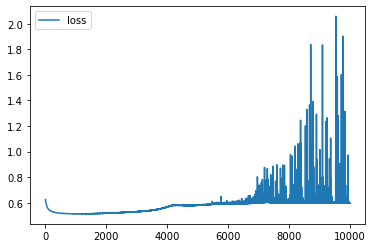

In [110]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [111]:
y_pred = model.predict(scaled_X_val)
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.
print(classification_report(y_val, y_pred))
confusion_matrix(y_val, y_pred)

              precision    recall  f1-score   support

           0       0.30      0.69      0.41     40154
           1       0.88      0.59      0.71    161353

    accuracy                           0.61    201507
   macro avg       0.59      0.64      0.56    201507
weighted avg       0.77      0.61      0.65    201507



array([[27579, 12575],
       [65871, 95482]], dtype=int64)

In [113]:
model.save('121_121_121_1_e10000_model.h5')  

In [ ]:
# model = load_model('121_121_121_1_e10000_model.h5')

This is much better performance and comparable to some of the other models. At about 2000 epochs(probably even less than that), the model is likely well trained. We will use 2000 epochs for all other model training.

Let's retrain the same model but for 2000 epochs

In [52]:
model = Sequential()

model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

In [53]:
model.fit(x=scaled_X_train, 
          y=y_train, 
          epochs=2000,
          batch_size=256,
          class_weight=weights
      )

Epoch 1/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6248
Epoch 2/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6201
Epoch 3/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6183
Epoch 4/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6169
Epoch 5/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6157
Epoch 6/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6146
Epoch 7/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6134A: 0s -
Epoch 8/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6123
Epoch 9/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6111
Epoch 10/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6099
Epoch 11/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6087
Epoch 12/2000
3674/3674 [==============================]

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5381
Epoch 191/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5379
Epoch 192/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5379
Epoch 193/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5376
Epoch 194/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5375
Epoch 195/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5378
Epoch 196/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5376
Epoch 197/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5376
Epoch 198/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5375
Epoch 199/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5371
Epoch 200/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5369
Epoch 201/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5265
Epoch 379/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5270
Epoch 380/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5263
Epoch 381/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5265
Epoch 382/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5268
Epoch 383/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5258
Epoch 384/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5267
Epoch 385/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5261
Epoch 386/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5267
Epoch 387/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5262
Epoch 388/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5260
Epoch 389/2000
3674/3674 [==============================] 

Epoch 566/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5220
Epoch 567/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5219
Epoch 568/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5220
Epoch 569/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5220
Epoch 570/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5217
Epoch 571/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5225
Epoch 572/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5222
Epoch 573/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5222
Epoch 574/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5220
Epoch 575/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5218
Epoch 576/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5218
Epoch 577/2000
3674/3674 [=================

Epoch 660/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5209
Epoch 661/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5208
Epoch 662/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5212
Epoch 663/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5205
Epoch 664/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5213
Epoch 665/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5209
Epoch 666/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5206
Epoch 667/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5207
Epoch 668/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5210
Epoch 669/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5205
Epoch 670/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5209
Epoch 671/2000
3674/3674 [=================

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5200
Epoch 755/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5199
Epoch 756/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5201
Epoch 757/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5200
Epoch 758/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5202
Epoch 759/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5201
Epoch 760/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.5199
Epoch 761/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5196
Epoch 762/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5197
Epoch 763/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5196
Epoch 764/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5201
Epoch 765/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5197
Epoch 943/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5193
Epoch 944/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5197
Epoch 945/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5191
Epoch 946/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5197
Epoch 947/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5194
Epoch 948/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5193
Epoch 949/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5194
Epoch 950/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5194
Epoch 951/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5191
Epoch 952/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5195
Epoch 953/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5196
Epoch 1129/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5191
Epoch 1130/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5194
Epoch 1131/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5198
Epoch 1132/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5193
Epoch 1133/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5194
Epoch 1134/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5193
Epoch 1135/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5198
Epoch 1136/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5197
Epoch 1137/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5191
Epoch 1138/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5196
Epoch 1139/2000
3674/3674 [=====================

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5206
Epoch 1315/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5205
Epoch 1316/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5202
Epoch 1317/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5202
Epoch 1318/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5200
Epoch 1319/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5205
Epoch 1320/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5207
Epoch 1321/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5205
Epoch 1322/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5202
Epoch 1323/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5204
Epoch 1324/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5202
Epoch 1325/2000
3674/3674 [=====================

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5211
Epoch 1501/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5211
Epoch 1502/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5210
Epoch 1503/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5209
Epoch 1504/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5219
Epoch 1505/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5208
Epoch 1506/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5212
Epoch 1507/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5211
Epoch 1508/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5213
Epoch 1509/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5208
Epoch 1510/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5213
Epoch 1511/2000
3674/3674 [=====================

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5226
Epoch 1687/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5228
Epoch 1688/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5222
Epoch 1689/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5228
Epoch 1690/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5219
Epoch 1691/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5226
Epoch 1692/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5230
Epoch 1693/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5225
Epoch 1694/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5221
Epoch 1695/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5231
Epoch 1696/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5225
Epoch 1697/2000
3674/3674 [=====================

3674/3674 [==============================] - 5s 1ms/step - loss: 0.5249
Epoch 1873/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5247
Epoch 1874/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5249
Epoch 1875/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5244
Epoch 1876/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5247
Epoch 1877/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5256
Epoch 1878/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5247
Epoch 1879/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5248
Epoch 1880/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5250
Epoch 1881/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5251
Epoch 1882/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.5254
Epoch 1883/2000
3674/3674 [=====================

<AxesSubplot:>

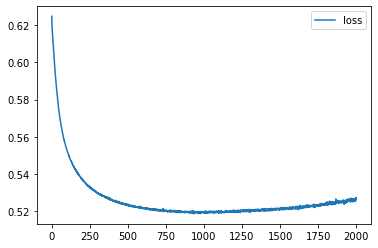

In [54]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [55]:
y_pred = model.predict(scaled_X_val)
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.
print(classification_report(y_val, y_pred))
confusion_matrix(y_val, y_pred)

              precision    recall  f1-score   support

           0       0.29      0.65      0.40     40154
           1       0.88      0.60      0.71    161353

    accuracy                           0.61    201507
   macro avg       0.58      0.63      0.56    201507
weighted avg       0.76      0.61      0.65    201507



array([[26296, 13858],
       [63950, 97403]], dtype=int64)

In [102]:
ann = ['121_121_121', 0.40, 0.71, 0.61, 0.56, 0.65]

In [103]:
model_results.append(ann)

In [104]:
model_results

[['121_121_121_121', 0.41, 0.72, 0.62, 0.56, 0.66],
 ['121_242_121_60', 0.39, 0.72, 0.61, 0.56, 0.65],
 ['121_242_242_242', 0.4, 0.72, 0.62, 0.56, 0.66],
 ['121_242_121_121', 0.4, 0.71, 0.61, 0.56, 0.65],
 ['121_484_121', 0.39, 0.72, 0.61, 0.55, 0.65],
 ['121_242_121', 0.4, 0.73, 0.63, 0.57, 0.67],
 ['121_121_121', 0.4, 0.71, 0.61, 0.56, 0.65]]

Let's try a large hidden layer

In [48]:
model = Sequential()

model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=242,activation='relu'))
model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

In [49]:
model.fit(x=scaled_X_train, 
          y=y_train, 
          epochs=2000,
          batch_size=256,
          class_weight=weights
      )

Epoch 1/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6249
Epoch 2/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6202
Epoch 3/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6183
Epoch 4/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6168
Epoch 5/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6155
Epoch 6/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6142
Epoch 7/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6130
Epoch 8/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6118
Epoch 9/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6103
Epoch 10/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6089
Epoch 11/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6074
Epoch 12/2000
3674/3674 [==============================] - 5s 1

3674/3674 [==============================] - 5s 1ms/step - loss: 0.4985
Epoch 191/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4981
Epoch 192/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4985
Epoch 193/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4981
Epoch 194/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4973
Epoch 195/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4979
Epoch 196/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4979
Epoch 197/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4969
Epoch 198/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4974
Epoch 199/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4970
Epoch 200/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4970
Epoch 201/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 5s 1ms/step - loss: 0.4808
Epoch 379/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4802
Epoch 380/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4803
Epoch 381/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4805
Epoch 382/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4799
Epoch 383/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4798
Epoch 384/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4799
Epoch 385/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4797
Epoch 386/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4802
Epoch 387/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4791
Epoch 388/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4797
Epoch 389/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 5s 1ms/step - loss: 0.4730
Epoch 567/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4727
Epoch 568/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4732
Epoch 569/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4732
Epoch 570/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4728
Epoch 571/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4727
Epoch 572/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4720
Epoch 573/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4727
Epoch 574/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4724
Epoch 575/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4723
Epoch 576/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4726
Epoch 577/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 5s 1ms/step - loss: 0.4694
Epoch 755/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4696
Epoch 756/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4693
Epoch 757/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4692
Epoch 758/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4688
Epoch 759/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4693
Epoch 760/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4695
Epoch 761/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4696
Epoch 762/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4688
Epoch 763/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4696
Epoch 764/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4692
Epoch 765/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 5s 1ms/step - loss: 0.4676
Epoch 943/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4684
Epoch 944/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4684
Epoch 945/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4680
Epoch 946/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4680
Epoch 947/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4681
Epoch 948/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4685
Epoch 949/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4691
Epoch 950/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4674
Epoch 951/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4687
Epoch 952/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4678
Epoch 953/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 5s 1ms/step - loss: 0.4686
Epoch 1129/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4691
Epoch 1130/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4703
Epoch 1131/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4686
Epoch 1132/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4689
Epoch 1133/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4691
Epoch 1134/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4687
Epoch 1135/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4688A: 0s - loss: 0.
Epoch 1136/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.4682
Epoch 1137/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.4702
Epoch 1138/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.4692
Epoch 1139/2000
3674/3674 [=====

3674/3674 [==============================] - 4s 1ms/step - loss: 0.4704
Epoch 1313/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4697
Epoch 1314/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4704
Epoch 1315/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4707
Epoch 1316/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4702
Epoch 1317/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4701
Epoch 1318/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4704
Epoch 1319/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4696
Epoch 1320/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4703
Epoch 1321/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4715
Epoch 1322/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4706
Epoch 1323/2000
3674/3674 [=====================

3674/3674 [==============================] - 5s 1ms/step - loss: 0.4724
Epoch 1498/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4738
Epoch 1499/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4744
Epoch 1500/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4735A: 0s - l
Epoch 1501/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4740
Epoch 1502/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4724
Epoch 1503/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4733
Epoch 1504/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4739
Epoch 1505/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4733
Epoch 1506/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.4729
Epoch 1507/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.4732
Epoch 1508/2000
3674/3674 [============

3674/3674 [==============================] - 5s 1ms/step - loss: 0.4747
Epoch 1591/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4739
Epoch 1592/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4752
Epoch 1593/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4748
Epoch 1594/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4752
Epoch 1595/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4754
Epoch 1596/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4739
Epoch 1597/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4760
Epoch 1598/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4756
Epoch 1599/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4742
Epoch 1600/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4752
Epoch 1601/2000
3674/3674 [=====================

3674/3674 [==============================] - 5s 1ms/step - loss: 0.4804
Epoch 1777/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4804
Epoch 1778/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4798
Epoch 1779/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4818
Epoch 1780/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4779
Epoch 1781/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4796
Epoch 1782/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4803
Epoch 1783/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4792
Epoch 1784/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4804
Epoch 1785/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4812
Epoch 1786/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4809
Epoch 1787/2000
3674/3674 [=====================

3674/3674 [==============================] - 5s 1ms/step - loss: 0.4806
Epoch 1870/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4821
Epoch 1871/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4829
Epoch 1872/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4831
Epoch 1873/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4823
Epoch 1874/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.4849
Epoch 1875/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.4824
Epoch 1876/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4832
Epoch 1877/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4818
Epoch 1878/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4842
Epoch 1879/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4828
Epoch 1880/2000
3674/3674 [=====================

<AxesSubplot:>

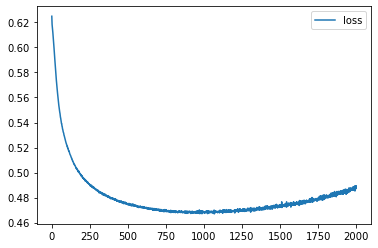

In [50]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [51]:
y_pred = model.predict(scaled_X_val)
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.
print(classification_report(y_val, y_pred))
confusion_matrix(y_val, y_pred)

              precision    recall  f1-score   support

           0       0.30      0.62      0.40     40154
           1       0.87      0.63      0.73    161353

    accuracy                           0.63    201507
   macro avg       0.58      0.63      0.57    201507
weighted avg       0.76      0.63      0.67    201507



array([[ 25021,  15133],
       [ 59187, 102166]], dtype=int64)

In [99]:
ann = ['121_242_121', 0.40, 0.73, 0.63, 0.57, 0.67]

In [100]:
model_results.append(ann)

In [101]:
model_results

[['121_121_121_121', 0.41, 0.72, 0.62, 0.56, 0.66],
 ['121_242_121_60', 0.39, 0.72, 0.61, 0.56, 0.65],
 ['121_242_242_242', 0.4, 0.72, 0.62, 0.56, 0.66],
 ['121_242_121_121', 0.4, 0.71, 0.61, 0.56, 0.65],
 ['121_484_121', 0.39, 0.72, 0.61, 0.55, 0.65],
 ['121_242_121', 0.4, 0.73, 0.63, 0.57, 0.67]]

An even larger hidden layer

In [56]:
model = Sequential()

model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=484,activation='relu'))
model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

In [57]:
model.fit(x=scaled_X_train, 
          y=y_train, 
          epochs=2000,
          batch_size=256,
          class_weight=weights
      )

Epoch 1/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6248
Epoch 2/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6201
Epoch 3/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6183
Epoch 4/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6169
Epoch 5/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6155
Epoch 6/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6141
Epoch 7/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6128
Epoch 8/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6116
Epoch 9/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6101
Epoch 10/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6088
Epoch 11/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6072
Epoch 12/2000
3674/3674 [==============================] - 5s 1

3674/3674 [==============================] - 5s 1ms/step - loss: 0.4546
Epoch 191/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4543
Epoch 192/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4544
Epoch 193/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4539
Epoch 194/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4533
Epoch 195/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4529
Epoch 196/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4532
Epoch 197/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4526
Epoch 198/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4532
Epoch 199/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4529
Epoch 200/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4520
Epoch 201/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 5s 1ms/step - loss: 0.4307
Epoch 379/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4298
Epoch 380/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4306
Epoch 381/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4295
Epoch 382/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4297
Epoch 383/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4298
Epoch 384/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4295
Epoch 385/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4299
Epoch 386/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4297
Epoch 387/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4294
Epoch 388/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4298
Epoch 389/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 5s 1ms/step - loss: 0.4202
Epoch 567/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4210
Epoch 568/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4197
Epoch 569/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4197
Epoch 570/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4200
Epoch 571/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4196
Epoch 572/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4201
Epoch 573/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4199
Epoch 574/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4200
Epoch 575/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4190
Epoch 576/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4201
Epoch 577/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 5s 1ms/step - loss: 0.4162
Epoch 755/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4159
Epoch 756/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4151
Epoch 757/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4163
Epoch 758/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.4161
Epoch 759/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.4152
Epoch 760/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4160
Epoch 761/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.4154
Epoch 762/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.4159
Epoch 763/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.4155
Epoch 764/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4148
Epoch 765/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 5s 1ms/step - loss: 0.4147
Epoch 849/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4142
Epoch 850/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4142
Epoch 851/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4157
Epoch 852/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4145
Epoch 853/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4143
Epoch 854/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4147
Epoch 855/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4144
Epoch 856/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4153
Epoch 857/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4140
Epoch 858/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4150
Epoch 859/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 5s 1ms/step - loss: 0.4141
Epoch 943/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4140
Epoch 944/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4145
Epoch 945/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4145
Epoch 946/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4139
Epoch 947/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4143
Epoch 948/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4137
Epoch 949/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4142
Epoch 950/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4132
Epoch 951/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4152
Epoch 952/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4145
Epoch 953/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 5s 1ms/step - loss: 0.4151
Epoch 1129/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4138
Epoch 1130/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4141
Epoch 1131/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4144
Epoch 1132/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4142
Epoch 1133/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4142
Epoch 1134/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4147
Epoch 1135/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4145
Epoch 1136/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4146
Epoch 1137/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4144
Epoch 1138/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4144
Epoch 1139/2000
3674/3674 [=====================

3674/3674 [==============================] - 5s 1ms/step - loss: 0.4156
Epoch 1315/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4160
Epoch 1316/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4165
Epoch 1317/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4165
Epoch 1318/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4171
Epoch 1319/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4175
Epoch 1320/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4153
Epoch 1321/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4174
Epoch 1322/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4159
Epoch 1323/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4160
Epoch 1324/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4169
Epoch 1325/2000
3674/3674 [=====================

3674/3674 [==============================] - 5s 1ms/step - loss: 0.4198
Epoch 1501/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4175
Epoch 1502/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.4181
Epoch 1503/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.4201
Epoch 1504/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.4172
Epoch 1505/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.4214
Epoch 1506/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.4194
Epoch 1507/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4200
Epoch 1508/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4192
Epoch 1509/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4197
Epoch 1510/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4193
Epoch 1511/2000
3674/3674 [=====================

3674/3674 [==============================] - 5s 1ms/step - loss: 0.4244
Epoch 1687/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4241
Epoch 1688/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4208
Epoch 1689/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4253
Epoch 1690/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4229
Epoch 1691/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4217
Epoch 1692/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4247
Epoch 1693/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.4211
Epoch 1694/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.4239
Epoch 1695/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.4217
Epoch 1696/2000
3674/3674 [==============================] - 4s 1ms/step - loss: 0.4234
Epoch 1697/2000
3674/3674 [=====================

3674/3674 [==============================] - 5s 1ms/step - loss: 0.4254
Epoch 1873/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4286
Epoch 1874/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4271
Epoch 1875/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4270
Epoch 1876/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4278
Epoch 1877/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4258
Epoch 1878/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4276
Epoch 1879/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4285
Epoch 1880/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4275
Epoch 1881/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4310
Epoch 1882/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.4263
Epoch 1883/2000
3674/3674 [=====================

<AxesSubplot:>

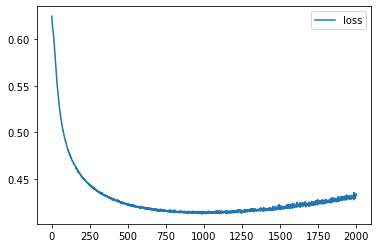

In [58]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [59]:
y_pred = model.predict(scaled_X_val)
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.
print(classification_report(y_val, y_pred))
confusion_matrix(y_val, y_pred)

              precision    recall  f1-score   support

           0       0.29      0.63      0.39     40154
           1       0.87      0.61      0.72    161353

    accuracy                           0.61    201507
   macro avg       0.58      0.62      0.55    201507
weighted avg       0.75      0.61      0.65    201507



array([[25471, 14683],
       [63401, 97952]], dtype=int64)

In [96]:
ann = ['121_484_121', 0.39, 0.72, 0.61, 0.55, 0.65]

In [97]:
model_results.append(ann)

In [98]:
model_results

[['121_121_121_121', 0.41, 0.72, 0.62, 0.56, 0.66],
 ['121_242_121_60', 0.39, 0.72, 0.61, 0.56, 0.65],
 ['121_242_242_242', 0.4, 0.72, 0.62, 0.56, 0.66],
 ['121_242_121_121', 0.4, 0.71, 0.61, 0.56, 0.65],
 ['121_484_121', 0.39, 0.72, 0.61, 0.55, 0.65]]

A much deeper network

In [32]:
model = Sequential()

model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=242,activation='relu'))
model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

In [33]:
model.fit(x=scaled_X_train, 
          y=y_train, 
          epochs=2000,
          batch_size=256,
          class_weight=weights
      )

Epoch 1/2000
3674/3674 [==============================] - 7s 1ms/step - loss: 0.6253
Epoch 2/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6204
Epoch 3/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6186
Epoch 4/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6171
Epoch 5/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6159
Epoch 6/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6148
Epoch 7/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6135
Epoch 8/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6122
Epoch 9/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6110
Epoch 10/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6097
Epoch 11/2000
3674/3674 [==============================] - 5s 1ms/step - loss: 0.6082
Epoch 12/2000
3674/3674 [==============================] - 5s 1

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4921
Epoch 189/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4919
Epoch 190/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4919
Epoch 191/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4918
Epoch 192/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4910
Epoch 193/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4909
Epoch 194/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4907
Epoch 195/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4895
Epoch 196/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4900
Epoch 197/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4904
Epoch 198/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4894
Epoch 199/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4708
Epoch 376/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4696
Epoch 377/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4711
Epoch 378/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4709
Epoch 379/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4691
Epoch 380/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4701
Epoch 381/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4704
Epoch 382/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4685
Epoch 383/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4700
Epoch 384/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4694
Epoch 385/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4698
Epoch 386/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4638
Epoch 563/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4628
Epoch 564/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4641
Epoch 565/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4633
Epoch 566/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4639
Epoch 567/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4631
Epoch 568/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4628
Epoch 569/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4626
Epoch 570/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4633
Epoch 571/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4633
Epoch 572/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4628
Epoch 573/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4617
Epoch 657/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4627
Epoch 658/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4620
Epoch 659/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4620
Epoch 660/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4615
Epoch 661/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4617
Epoch 662/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4615
Epoch 663/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4609
Epoch 664/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4623
Epoch 665/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4612
Epoch 666/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4629
Epoch 667/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4607
Epoch 845/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4621
Epoch 846/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4625
Epoch 847/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4617
Epoch 848/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4605
Epoch 849/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4619
Epoch 850/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4620
Epoch 851/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4623
Epoch 852/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4614
Epoch 853/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4618
Epoch 854/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4620
Epoch 855/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4619
Epoch 1032/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4636
Epoch 1033/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4613
Epoch 1034/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4629
Epoch 1035/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4651
Epoch 1036/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4620
Epoch 1037/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4616
Epoch 1038/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4624
Epoch 1039/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4623
Epoch 1040/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4631
Epoch 1041/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4612
Epoch 1042/2000
3674/3674 [=====================

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4627
Epoch 1125/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4634
Epoch 1126/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4625
Epoch 1127/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4634
Epoch 1128/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4640
Epoch 1129/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4642
Epoch 1130/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4628
Epoch 1131/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4632
Epoch 1132/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4635
Epoch 1133/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4630
Epoch 1134/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4635
Epoch 1135/2000
3674/3674 [=====================

Epoch 1217/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4646
Epoch 1218/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4645
Epoch 1219/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4642
Epoch 1220/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4640
Epoch 1221/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4645
Epoch 1222/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4651
Epoch 1223/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4642
Epoch 1224/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4640
Epoch 1225/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4650
Epoch 1226/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4638
Epoch 1227/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4627
Epoch 1228/2000
3674/3674 [=====

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4662
Epoch 1311/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4647
Epoch 1312/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4640
Epoch 1313/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4675
Epoch 1314/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4646A: 0s - loss: 0.46
Epoch 1315/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4651
Epoch 1316/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4645
Epoch 1317/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4645
Epoch 1318/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4658
Epoch 1319/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4655
Epoch 1320/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4667
Epoch 1321/2000
3674/3674 [===

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4672
Epoch 1404/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4672
Epoch 1405/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4663
Epoch 1406/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4678
Epoch 1407/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4680
Epoch 1408/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4667
Epoch 1409/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4663
Epoch 1410/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4667
Epoch 1411/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4670
Epoch 1412/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4677
Epoch 1413/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4656
Epoch 1414/2000
3674/3674 [=====================

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4681
Epoch 1590/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4706
Epoch 1591/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4678
Epoch 1592/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4679
Epoch 1593/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4713
Epoch 1594/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4683
Epoch 1595/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4687
Epoch 1596/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4721
Epoch 1597/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4681
Epoch 1598/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4702
Epoch 1599/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4682
Epoch 1600/2000
3674/3674 [=====================

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4731
Epoch 1775/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4728
Epoch 1776/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4735
Epoch 1777/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4717
Epoch 1778/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4728
Epoch 1779/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4718
Epoch 1780/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4727
Epoch 1781/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4709
Epoch 1782/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4715
Epoch 1783/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4731
Epoch 1784/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4698
Epoch 1785/2000
3674/3674 [=====================

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4720
Epoch 1961/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4741
Epoch 1962/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4745
Epoch 1963/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4736
Epoch 1964/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4730
Epoch 1965/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4735
Epoch 1966/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4717
Epoch 1967/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4744
Epoch 1968/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4749
Epoch 1969/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4741
Epoch 1970/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4754
Epoch 1971/2000
3674/3674 [=====================

<AxesSubplot:>

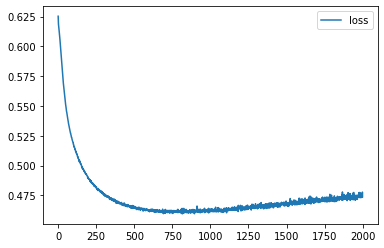

In [34]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [35]:
y_pred = model.predict(scaled_X_val)
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.
print(classification_report(y_val, y_pred))
confusion_matrix(y_val, y_pred)

              precision    recall  f1-score   support

           0       0.29      0.65      0.40     40154
           1       0.87      0.60      0.71    161353

    accuracy                           0.61    201507
   macro avg       0.58      0.63      0.56    201507
weighted avg       0.76      0.61      0.65    201507



array([[26040, 14114],
       [63942, 97411]], dtype=int64)

In [93]:
ann = ['121_242_121_121', 0.40, 0.71, 0.61, 0.56, 0.65]

In [94]:
model_results.append(ann)

An even more complex model

In [36]:
model = Sequential()

model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=242,activation='relu'))
model.add(Dense(units=242,activation='relu'))
model.add(Dense(units=242,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

In [37]:
model.fit(x=scaled_X_train, 
          y=y_train, 
          epochs=2000,
          batch_size=256,
          class_weight=weights
      )

Epoch 1/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6251
Epoch 2/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6204
Epoch 3/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6185
Epoch 4/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6170
Epoch 5/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6156
Epoch 6/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6142
Epoch 7/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6132
Epoch 8/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6120
Epoch 9/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6108
Epoch 10/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6094
Epoch 11/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6081
Epoch 12/2000
3674/3674 [==============================] - 6s 2

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4682
Epoch 191/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4681
Epoch 192/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4679
Epoch 193/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4677
Epoch 194/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4679
Epoch 195/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4672
Epoch 196/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4677
Epoch 197/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4662
Epoch 198/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4670
Epoch 199/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4665A: 0s - loss: 0.466
Epoch 200/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4653
Epoch 201/2000
3674/3674 [=============

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4410
Epoch 378/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4422
Epoch 379/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4416
Epoch 380/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4395
Epoch 381/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4404
Epoch 382/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4418
Epoch 383/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4405
Epoch 384/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4412
Epoch 385/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4393
Epoch 386/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4394
Epoch 387/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4394
Epoch 388/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4351
Epoch 564/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4337
Epoch 565/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4343
Epoch 566/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4327
Epoch 567/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4332
Epoch 568/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4336
Epoch 569/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4325
Epoch 570/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4334
Epoch 571/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4335
Epoch 572/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4338
Epoch 573/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4341
Epoch 574/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4342
Epoch 752/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4317
Epoch 753/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4328
Epoch 754/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4312
Epoch 755/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4321
Epoch 756/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4311
Epoch 757/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4322
Epoch 758/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4325
Epoch 759/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4318
Epoch 760/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4324
Epoch 761/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4302
Epoch 762/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4317
Epoch 846/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4322
Epoch 847/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4348
Epoch 848/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4334
Epoch 849/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4331A: 0s - loss: 0.433
Epoch 850/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4318
Epoch 851/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4327
Epoch 852/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4355
Epoch 853/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4351
Epoch 854/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4326
Epoch 855/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4319
Epoch 856/2000
3674/3674 [=============

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4372
Epoch 940/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4344
Epoch 941/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4331
Epoch 942/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4350
Epoch 943/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4334
Epoch 944/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4343
Epoch 945/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4356
Epoch 946/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4360
Epoch 947/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4361
Epoch 948/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4350
Epoch 949/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4353
Epoch 950/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 7s 2ms/step - loss: 0.4386
Epoch 1126/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4409
Epoch 1127/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4396
Epoch 1128/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4386
Epoch 1129/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4386
Epoch 1130/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4376
Epoch 1131/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4400
Epoch 1132/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4406
Epoch 1133/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4404
Epoch 1134/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4375
Epoch 1135/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4418
Epoch 1136/2000
3674/3674 [=====================

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4477
Epoch 1312/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4488
Epoch 1313/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4433
Epoch 1314/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4456
Epoch 1315/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4450
Epoch 1316/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4452
Epoch 1317/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4449
Epoch 1318/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4443
Epoch 1319/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4475
Epoch 1320/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4434
Epoch 1321/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4465
Epoch 1322/2000
3674/3674 [=====================

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4478
Epoch 1405/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4474
Epoch 1406/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4482
Epoch 1407/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4469
Epoch 1408/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4490
Epoch 1409/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4488
Epoch 1410/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4464
Epoch 1411/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4490
Epoch 1412/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4473
Epoch 1413/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4515
Epoch 1414/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4519
Epoch 1415/2000
3674/3674 [=====================

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4522
Epoch 1591/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4586
Epoch 1592/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4554
Epoch 1593/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4555
Epoch 1594/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4549
Epoch 1595/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4541
Epoch 1596/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4561
Epoch 1597/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4602
Epoch 1598/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4534
Epoch 1599/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4545
Epoch 1600/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4607
Epoch 1601/2000
3674/3674 [=====================

Epoch 1683/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4586
Epoch 1684/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4589
Epoch 1685/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4591
Epoch 1686/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4601
Epoch 1687/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4588
Epoch 1688/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4623
Epoch 1689/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4599
Epoch 1690/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4604
Epoch 1691/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4603
Epoch 1692/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4600
Epoch 1693/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4632
Epoch 1694/2000
3674/3674 [=====

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4701
Epoch 1868/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4668
Epoch 1869/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4700
Epoch 1870/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4670
Epoch 1871/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4693
Epoch 1872/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4690
Epoch 1873/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4714
Epoch 1874/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4681
Epoch 1875/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4677
Epoch 1876/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4709
Epoch 1877/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4682
Epoch 1878/2000
3674/3674 [=====================

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4733
Epoch 1961/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4748
Epoch 1962/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4725
Epoch 1963/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4745
Epoch 1964/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4704
Epoch 1965/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4728
Epoch 1966/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4697
Epoch 1967/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4744
Epoch 1968/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4761
Epoch 1969/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4737
Epoch 1970/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4735
Epoch 1971/2000
3674/3674 [=====================

<AxesSubplot:>

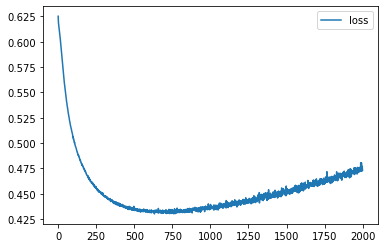

In [38]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [39]:
y_pred = model.predict(scaled_X_val)
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.
print(classification_report(y_val, y_pred))
confusion_matrix(y_val, y_pred)

              precision    recall  f1-score   support

           0       0.29      0.63      0.40     40154
           1       0.87      0.62      0.72    161353

    accuracy                           0.62    201507
   macro avg       0.58      0.62      0.56    201507
weighted avg       0.75      0.62      0.66    201507



array([[25190, 14964],
       [61519, 99834]], dtype=int64)

In [90]:
ann = ['121_242_242_242', 0.40, 0.72, 0.62, 0.56, 0.66]

In [91]:
model_results.append(ann)

In [92]:
model_results

[['121_121_121_121', 0.41, 0.72, 0.62, 0.56, 0.66],
 ['121_242_121_60', 0.39, 0.72, 0.61, 0.56, 0.65],
 ['121_242_242_242', 0.4, 0.72, 0.62, 0.56, 0.66]]

Let's try filtering the number of nodes down to promote a stronger signal across the feedforward network

In [40]:
model = Sequential()

model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=242,activation='relu'))
model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=60,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

In [41]:
model.fit(x=scaled_X_train, 
          y=y_train, 
          epochs=2000,
          batch_size=256,
          class_weight=weights
      )

Epoch 1/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.6254
Epoch 2/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6204
Epoch 3/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6183
Epoch 4/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6168
Epoch 5/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6156
Epoch 6/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6142
Epoch 7/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6131
Epoch 8/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6118
Epoch 9/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6105
Epoch 10/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6092
Epoch 11/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6079
Epoch 12/2000
3674/3674 [==============================] - 6s 2

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4904
Epoch 191/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4907
Epoch 192/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4897
Epoch 193/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4897
Epoch 194/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4896
Epoch 195/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4896
Epoch 196/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4887
Epoch 197/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4886
Epoch 198/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4894
Epoch 199/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4878
Epoch 200/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4881
Epoch 201/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4774
Epoch 285/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4777
Epoch 286/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4768
Epoch 287/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4775
Epoch 288/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4774
Epoch 289/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4766
Epoch 290/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4766
Epoch 291/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4772A
Epoch 292/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4769
Epoch 293/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4770
Epoch 294/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4769A: 0
Epoch 295/2000
3674/3674 [===========================

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4700
Epoch 379/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4698
Epoch 380/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4707
Epoch 381/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4696
Epoch 382/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4700
Epoch 383/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4694
Epoch 384/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4696
Epoch 385/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4697
Epoch 386/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4695
Epoch 387/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4691
Epoch 388/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4704
Epoch 389/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4621
Epoch 567/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4629
Epoch 568/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4626
Epoch 569/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4636
Epoch 570/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4634A: 0s - loss: 0.4
Epoch 571/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4639
Epoch 572/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4632
Epoch 573/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4624
Epoch 574/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4629
Epoch 575/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4639
Epoch 576/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4622
Epoch 577/2000
3674/3674 [===============

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4607
Epoch 754/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4610
Epoch 755/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4605
Epoch 756/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4600
Epoch 757/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4601
Epoch 758/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4603
Epoch 759/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4607
Epoch 760/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4599
Epoch 761/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4611
Epoch 762/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4620
Epoch 763/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4606
Epoch 764/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4602
Epoch 942/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4618
Epoch 943/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4610
Epoch 944/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4609
Epoch 945/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4607
Epoch 946/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4622
Epoch 947/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4613
Epoch 948/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4627
Epoch 949/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4620
Epoch 950/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4607
Epoch 951/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4613
Epoch 952/2000
3674/3674 [==============================] 

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4637
Epoch 1128/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4630
Epoch 1129/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4613
Epoch 1130/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4639
Epoch 1131/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4629
Epoch 1132/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4648A: 0s - 
Epoch 1133/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4639
Epoch 1134/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4626
Epoch 1135/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4636
Epoch 1136/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4631
Epoch 1137/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4642
Epoch 1138/2000
3674/3674 [=============

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4663
Epoch 1313/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4645
Epoch 1314/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4667
Epoch 1315/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4657
Epoch 1316/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4648
Epoch 1317/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4674
Epoch 1318/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4657
Epoch 1319/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4647
Epoch 1320/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4662
Epoch 1321/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4645
Epoch 1322/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4660
Epoch 1323/2000
3674/3674 [=====================

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4688
Epoch 1499/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4694
Epoch 1500/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4663
Epoch 1501/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4712
Epoch 1502/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4676
Epoch 1503/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4681
Epoch 1504/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4682
Epoch 1505/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4701
Epoch 1506/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4702
Epoch 1507/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4674
Epoch 1508/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4724
Epoch 1509/2000
3674/3674 [=====================

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4720
Epoch 1592/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4721A: 0s - loss: 0
Epoch 1593/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4684A: 2s
Epoch 1594/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4697
Epoch 1595/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4689
Epoch 1596/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4713
Epoch 1597/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4696
Epoch 1598/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4725
Epoch 1599/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4702
Epoch 1600/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4709
Epoch 1601/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4711
Epoch 1602/2000
3674/3674 [=

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4719
Epoch 1777/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4750
Epoch 1778/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4712
Epoch 1779/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4733
Epoch 1780/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4743
Epoch 1781/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4756
Epoch 1782/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4736
Epoch 1783/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4747
Epoch 1784/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4768
Epoch 1785/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4712
Epoch 1786/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4728
Epoch 1787/2000
3674/3674 [=====================

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4724
Epoch 1963/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4774
Epoch 1964/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4764
Epoch 1965/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4737
Epoch 1966/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4756
Epoch 1967/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4779
Epoch 1968/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4760
Epoch 1969/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4813
Epoch 1970/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4778
Epoch 1971/2000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4742
Epoch 1972/2000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4772
Epoch 1973/2000
3674/3674 [=====================

<AxesSubplot:>

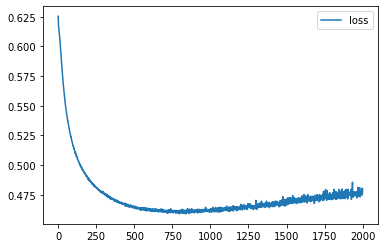

In [42]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [43]:
y_pred = model.predict(scaled_X_val)
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.
print(classification_report(y_val, y_pred))
confusion_matrix(y_val, y_pred)

              precision    recall  f1-score   support

           0       0.29      0.63      0.39     40154
           1       0.87      0.61      0.72    161353

    accuracy                           0.61    201507
   macro avg       0.58      0.62      0.56    201507
weighted avg       0.75      0.61      0.65    201507



array([[25305, 14849],
       [62744, 98609]], dtype=int64)

In [87]:
ann = ['121_242_121_60', 0.39, 0.72, 0.61, 0.56, 0.65]

In [88]:
model_results.append(ann)

In [89]:
model_results

[['121_121_121_121', 0.41, 0.72, 0.62, 0.56, 0.66],
 ['121_242_121_60', 0.39, 0.72, 0.61, 0.56, 0.65]]

In [28]:
model = Sequential()

model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

In [29]:
model.fit(x=scaled_X_train, 
          y=y_train, 
          epochs=750,
          batch_size=256,
          class_weight=weights
      )

Epoch 1/750
3674/3674 [==============================] - 9s 2ms/step - loss: 0.6251
Epoch 2/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6203
Epoch 3/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6184
Epoch 4/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6171
Epoch 5/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6157
Epoch 6/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6147
Epoch 7/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6135
Epoch 8/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6124
Epoch 9/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6114
Epoch 10/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6102
Epoch 11/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6091
Epoch 12/750
3674/3674 [==============================] - 6s 2ms/step - lo

3674/3674 [==============================] - 6s 2ms/step - loss: 0.5271
Epoch 193/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5277
Epoch 194/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5275
Epoch 195/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5277
Epoch 196/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5272
Epoch 197/750
3674/3674 [==============================] - 7s 2ms/step - loss: 0.5273
Epoch 198/750
3674/3674 [==============================] - 7s 2ms/step - loss: 0.5270
Epoch 199/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5270
Epoch 200/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5268
Epoch 201/750
3674/3674 [==============================] - 7s 2ms/step - loss: 0.5262
Epoch 202/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5263
Epoch 203/750
3674/3674 [==============================] - 6s 2ms/st

3674/3674 [==============================] - 7s 2ms/step - loss: 0.5126
Epoch 383/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5128
Epoch 384/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5130
Epoch 385/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5130
Epoch 386/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5123
Epoch 387/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5127
Epoch 388/750
3674/3674 [==============================] - 7s 2ms/step - loss: 0.5126
Epoch 389/750
3674/3674 [==============================] - 7s 2ms/step - loss: 0.5120
Epoch 390/750
3674/3674 [==============================] - 7s 2ms/step - loss: 0.5128
Epoch 391/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5129
Epoch 392/750
3674/3674 [==============================] - 7s 2ms/step - loss: 0.5118
Epoch 393/750
3674/3674 [==============================] - 7s 2ms/st

3674/3674 [==============================] - 6s 2ms/step - loss: 0.5090
Epoch 478/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5095
Epoch 479/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5103
Epoch 480/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5091
Epoch 481/750
3674/3674 [==============================] - 7s 2ms/step - loss: 0.5087
Epoch 482/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5095
Epoch 483/750
3674/3674 [==============================] - 7s 2ms/step - loss: 0.5087
Epoch 484/750
3674/3674 [==============================] - 7s 2ms/step - loss: 0.5088
Epoch 485/750
3674/3674 [==============================] - 7s 2ms/step - loss: 0.5096
Epoch 486/750
3674/3674 [==============================] - 7s 2ms/step - loss: 0.5088
Epoch 487/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5095
Epoch 488/750
3674/3674 [==============================] - 7s 2ms/st

3674/3674 [==============================] - 6s 2ms/step - loss: 0.5075
Epoch 667/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5072
Epoch 668/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5070
Epoch 669/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5075
Epoch 670/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5067
Epoch 671/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5068
Epoch 672/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5066
Epoch 673/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5071
Epoch 674/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5068
Epoch 675/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5066
Epoch 676/750
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5066
Epoch 677/750
3674/3674 [==============================] - 6s 2ms/st

<AxesSubplot:>

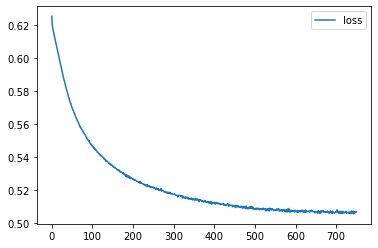

In [30]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [31]:
y_pred = model.predict(scaled_X_val)
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.
print(classification_report(y_val, y_pred))
confusion_matrix(y_val, y_pred)

              precision    recall  f1-score   support

           0       0.29      0.65      0.41     40154
           1       0.88      0.61      0.72    161353

    accuracy                           0.62    201507
   macro avg       0.58      0.63      0.56    201507
weighted avg       0.76      0.62      0.66    201507



array([[26289, 13865],
       [63231, 98122]], dtype=int64)

In [83]:
model_results = []

In [84]:
ann = ['121_121_121_121', 0.41, 0.72, 0.62, 0.56, 0.66]

In [85]:
model_results.append(ann)

In [86]:
model_results

[['121_121_121_121', 0.41, 0.72, 0.62, 0.56, 0.66]]

Now let's tabulate my results

In [106]:
model_results

[['121_121_121_121', 0.41, 0.72, 0.62, 0.56, 0.66],
 ['121_242_121_60', 0.39, 0.72, 0.61, 0.56, 0.65],
 ['121_242_242_242', 0.4, 0.72, 0.62, 0.56, 0.66],
 ['121_242_121_121', 0.4, 0.71, 0.61, 0.56, 0.65],
 ['121_484_121', 0.39, 0.72, 0.61, 0.55, 0.65],
 ['121_242_121', 0.4, 0.73, 0.63, 0.57, 0.67],
 ['121_121_121', 0.4, 0.71, 0.61, 0.56, 0.65]]

In [107]:
model_results_df = pd.DataFrame(data=model_results, columns=['ann_type', 'f1_score_0', 'f1_score_1', 'accuracy', 'macro_avg', 'weighted_avg'])

In [108]:
model_results_df

,ann_type,f1_score_0,f1_score_1,accuracy,macro_avg,weighted_avg
0,121_121_121_121,0.41,0.72,0.62,0.56,0.66
1,121_242_121_60,0.39,0.72,0.61,0.56,0.65
2,121_242_242_242,0.40,0.72,0.62,0.56,0.66
3,121_242_121_121,0.40,0.71,0.61,0.56,0.65
4,121_484_121,0.39,0.72,0.61,0.55,0.65
5,121_242_121,0.40,0.73,0.63,0.57,0.67
6,121_121_121,0.40,0.71,0.61,0.56,0.65


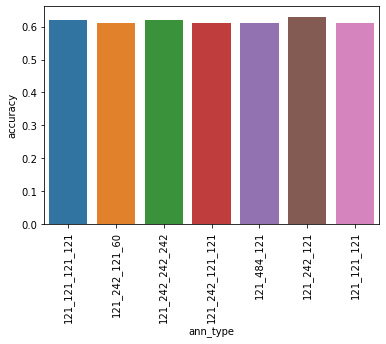

In [109]:
sns.barplot(data=model_results_df, x='ann_type', y='accuracy')
plt.xticks(rotation=90);

It looks like 121_242_121 ann architecture is giving the best results

In [150]:
model = Sequential()

model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=242,activation='relu'))
model.add(Dense(units=121,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

In [151]:
model.fit(x=scaled_X_train, 
          y=y_train, 
          epochs=1000,
          batch_size=256,
          class_weight=weights
      )

Epoch 1/1000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.6249
Epoch 2/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6202
Epoch 3/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6184
Epoch 4/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6170
Epoch 5/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6158
Epoch 6/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6147
Epoch 7/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6134
Epoch 8/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6122
Epoch 9/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6108
Epoch 10/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6095
Epoch 11/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.6079
Epoch 12/1000
3674/3674 [==============================] - 6s 2

3674/3674 [==============================] - 6s 2ms/step - loss: 0.5219
Epoch 97/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5217
Epoch 98/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5213
Epoch 99/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5209
Epoch 100/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5207
Epoch 101/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5206
Epoch 102/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5203
Epoch 103/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5195
Epoch 104/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5195
Epoch 105/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5191
Epoch 106/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.5185
Epoch 107/1000
3674/3674 [==============================] - 6

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4988
Epoch 191/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4982
Epoch 192/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4983
Epoch 193/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4981
Epoch 194/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4982
Epoch 195/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4978
Epoch 196/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4977
Epoch 197/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4980
Epoch 198/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4976
Epoch 199/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4975
Epoch 200/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4973
Epoch 201/1000
3674/3674 [==============================] 

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4868
Epoch 285/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4875
Epoch 286/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4869
Epoch 287/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4869
Epoch 288/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4869
Epoch 289/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4871
Epoch 290/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4865
Epoch 291/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4870
Epoch 292/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4868
Epoch 293/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4866
Epoch 294/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4864
Epoch 295/1000
3674/3674 [==============================] 

Epoch 378/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4805
Epoch 379/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4807
Epoch 380/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4800
Epoch 381/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4803
Epoch 382/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4803
Epoch 383/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4798
Epoch 384/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4803
Epoch 385/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4799
Epoch 386/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4798
Epoch 387/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4798
Epoch 388/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4800
Epoch 389/1000
3674/3674 [=================

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4727
Epoch 566/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4730
Epoch 567/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4731
Epoch 568/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4723
Epoch 569/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4724
Epoch 570/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4728
Epoch 571/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4728
Epoch 572/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4725
Epoch 573/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4726
Epoch 574/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4729
Epoch 575/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4722
Epoch 576/1000
3674/3674 [==============================] 

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4710
Epoch 660/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4703
Epoch 661/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4708
Epoch 662/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4702
Epoch 663/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4710
Epoch 664/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4702
Epoch 665/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4707
Epoch 666/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4710
Epoch 667/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4706
Epoch 668/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4707
Epoch 669/1000
3674/3674 [==============================] - 7s 2ms/step - loss: 0.4710
Epoch 670/1000
3674/3674 [==============================] 

3674/3674 [==============================] - 6s 2ms/step - loss: 0.4694
Epoch 848/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4686
Epoch 849/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4680
Epoch 850/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4681
Epoch 851/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4690
Epoch 852/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4690
Epoch 853/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4675
Epoch 854/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4680
Epoch 855/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4687
Epoch 856/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4677
Epoch 857/1000
3674/3674 [==============================] - 6s 2ms/step - loss: 0.4679
Epoch 858/1000
3674/3674 [==============================] 

<AxesSubplot:>

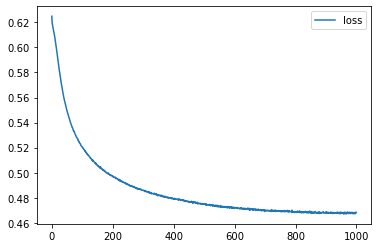

In [152]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [153]:
y_pred = model.predict(scaled_X_val)
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.
print(classification_report(y_val, y_pred))
confusion_matrix(y_val, y_pred)

              precision    recall  f1-score   support

           0       0.29      0.62      0.40     40154
           1       0.87      0.63      0.73    161353

    accuracy                           0.63    201507
   macro avg       0.58      0.63      0.57    201507
weighted avg       0.76      0.63      0.67    201507



array([[ 24914,  15240],
       [ 59607, 101746]], dtype=int64)

In [154]:
model.save('121_242_121_1_e1000_model.h5')  

In [167]:
y_pred = model.predict(scaled_X_val)
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.

In [170]:
results = pd.DataFrame(classification_report(y_val, y_pred,output_dict=True))

In [171]:
results

,0,1,accuracy,macro avg,weighted avg
precision,0.294767,0.869728,0.628564,0.582247,0.755156
recall,0.620461,0.630580,0.628564,0.625521,0.628564
f1-score,0.399663,0.731094,0.628564,0.565379,0.665050
support,40154.000000,161353.000000,0.628564,201507.000000,201507.000000


In [172]:
f1 = ['ann']
for i in np.array(results.loc['f1-score']):
    f1.append(i)
model_results.append(f1)

In [23]:
def _compute_class_weight_dictionary(df):
    # helper for returning a dictionary instead of an array
    classes = np.unique(df['loan_status'])
    class_weight = compute_class_weight("balanced", np.unique(df['loan_status']), np.array(df['loan_status']))
    class_weight_dict = dict(zip(classes, class_weight))
    return class_weight_dict 

In [24]:
weights = _compute_class_weight_dictionary(df)

C:\Users\kaile\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 0 1 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [25]:
weights

{0: 2.5045471833191644, 1: 0.6247164457291774}

In [26]:
scaler = MinMaxScaler()

In [27]:
scaled_X_train = scaler.fit_transform(X_train)

In [28]:
scaled_X_val = scaler.transform(X_val)

In [29]:
from keras.wrappers.scikit_learn import KerasClassifier

In [30]:
def ANN():
    
    model = Sequential()
    model.add(Dense(units=121,activation='relu'))
    model.add(Dense(units=242,activation='relu'))
    model.add(Dense(units=121,activation='relu'))
    model.add(Dense(units=1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
   
    return model

In [31]:
ann_clf = KerasClassifier(build_fn=ANN, epochs=1000, batch_size=256, verbose=0, class_weight=weights)

C:\Users\kaile\AppData\Local\Temp/ipykernel_15256/33027409.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  ann_clf = KerasClassifier(build_fn=ANN, epochs=1000, batch_size=256, verbose=0, class_weight=weights)


In [32]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X, y, scoring='balanced_accuracy', cv=cv, n_jobs=4)
    return scores

In [33]:
start=datetime.now()
scores = evaluate_model(ann_clf, scaled_X_train, y_train)
print(datetime.now()-start)

C:\Users\kaile\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


2 days, 6:58:41.572957


In [34]:
scores

array([0.61710291, 0.61746121, 0.61683749, 0.61532378, 0.61492336,
       0.61706404, 0.61755226, 0.61400005, 0.61553797, 0.61950742,
       0.61767451, 0.61324019, 0.6142688 , 0.61926083, 0.61600735])

In [36]:
scores_df = joblib.load('scores_df_7.pkl')

In [37]:
scores_df['ann'] = scores

In [38]:
scores_df

,logistic_regression,random_forest,AdaBoost,gradientboosting,svm_20pc_df,gaussian_nb,knn,ann
0,0.652997,0.653588,0.366759,0.552044,0.649066,0.607979,0.571684,0.617103
1,0.653641,0.652926,0.365666,0.546310,0.648673,0.608157,0.569974,0.617461
2,0.653698,0.654439,0.365139,0.542024,0.649482,0.605766,0.569819,0.616837
3,0.653548,0.653376,0.366311,0.552307,0.649059,0.632999,0.571401,0.615324
4,0.654409,0.652237,0.367433,0.550677,0.649491,0.607470,0.568388,0.614923
5,0.652379,0.652978,0.365814,0.552185,0.648201,0.607665,0.571836,0.617064
6,0.654146,0.652966,0.366477,0.552253,0.648757,0.608105,0.567773,0.617552
7,0.654311,0.653879,0.365523,0.552845,0.649055,0.608204,0.571267,0.614000
8,0.653494,0.653196,0.366330,0.549108,0.649024,0.606653,0.570624,0.615538
9,0.654074,0.652584,0.367164,0.552438,0.648299,0.632141,0.571928,0.619507


In [39]:
joblib.dump(scores_df, 'scores_df_final.pkl')

['scores_df_final.pkl']

## Model results processing

In [110]:
model_results = []

In [174]:
# model_results

In [184]:
model_results_df = pd.DataFrame(data=model_results, 
                                columns=['model', 'f1_score_0', 'f1_score_1', 'accuracy', 'macro_avg', 'weighted_avg'])

In [185]:
model_results_df

,model,f1_score_0,f1_score_1,accuracy,macro_avg,weighted_avg
0,logistic_regression,0.428401,0.737777,0.640484,0.583089,0.676129
1,random_forest,0.430754,0.769852,0.672225,0.600303,0.702281
2,AdaBoost,0.174548,0.520444,0.393336,0.347496,0.451518
3,gradientboosting,0.268516,0.844675,0.743761,0.556596,0.729865
4,SVM_20pc_df,0.432493,0.729972,0.634062,0.581233,0.670694
5,knn,0.338297,0.755146,0.642558,0.546722,0.672081
6,ann,0.399663,0.731094,0.628564,0.565379,0.665050
7,gaussian_naive_bayes,0.374116,0.830290,0.732982,0.602203,0.739389


In [186]:
joblib.dump(model_results_df, 'result_summary.pkl')

['result_summary.pkl']